In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree



In [2]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import itertools

In [3]:
from QuadraticConstraintModel import train_COF_on_leaves, get_h_from_COF

from QuadraticConstraintModel import get_feature_bounds_from_COF, predict_from_COF, get_elevated_vertices

from QuadraticConstraintModel import get_leaf_samples

from QuadraticConstraintModel import constrained_optimization_gurobi

In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [5]:
'''
def normalized_root_mean_square_error(y_true, y_pred):
    """
    Computes the Normalized Root Mean Square Error (NRMSE) between y_true and y_pred.
    Normalization is done using the range of y_true.

    Parameters:
        y_true (np.ndarray): Ground truth values, shape (n_samples, n_outputs)
        y_pred (np.ndarray): Predicted values, shape (n_samples, n_outputs)

    Returns:
        float: NRMSE value
    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    range_y = np.max(y_true) - np.min(y_true)
    return rmse / range_y if range_y != 0 else float('inf')
'''
def normalized_root_mean_square_error(y_true, y_pred):
    """
    Computes the Normalized Root Mean Square Error (NRMSE) between y_true and y_pred.
    If the range of y_true is zero, it normalizes by the number of samples * outputs.

    Parameters:
        y_true (np.ndarray): Ground truth values, shape (n_samples, n_outputs)
        y_pred (np.ndarray): Predicted values, shape (n_samples, n_outputs)

    Returns:
        float: NRMSE value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Compute range
    y_range = np.max(y_true) - np.min(y_true)
    
    if y_range != 0:
        # Normalize by range
        return rmse / y_range
    else:
        # Normalize by n_samples * n_outputs
        n_samples, n_outputs = y_true.shape
        return np.sqrt(np.sum((y_true - y_pred) ** 2) / (n_samples * n_outputs))

In [6]:
# Function to load DataSet
def load_dataset(file_path, num_attributes=2, num_classes=2):
    data = pd.read_csv(file_path)
    X = data.iloc[:, 0 :  num_attributes].values
    y = data.iloc[:,  num_attributes:  num_attributes + num_classes].values
    # y = data.iloc[:, 9:10].values
    return X, y

In [7]:

data_Directory = "Dataset/"



In [8]:
X,y = load_dataset(data_Directory + "SteamGovernor/data_SteamGovernor_10000000.csv",num_attributes = 3, num_classes = 3 )
print(f"Size of the Data Set\n Shape of X = {X.shape} \n Shape of y = {y.shape}")

Size of the Data Set
 Shape of X = (10000000, 3) 
 Shape of y = (10000000, 3)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1)
print(f" Shape of X_Training = {X_train.shape} \n Shape of X_Testing = {X_test.shape}")

# X_train = X
# y_train = y

 Shape of X_Training = (9000000, 3) 
 Shape of X_Testing = (1000000, 3)


In [10]:
X_train_backup = X_train.copy()
X_test_backup = X_test.copy()

y_train_backup = y_train.copy()
y_test_backup = y_test.copy()

In [42]:
from sklearn.preprocessing import StandardScaler
# --- StandardScaler for X ---
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)   # fit+transform on training
X_test = scaler_X.transform(X_test)         # transform only on test

# --- StandardScaler for y ---
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)   # fit+transform on training
y_test = scaler_y.transform(y_test)         # transform only on test

In [11]:
tree = DecisionTreeRegressor(min_samples_leaf=1000000)
tree.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=1000000)

In [12]:
tree.predict(X_train[0:5])

array([[-0.68763421,  2.06242183,  0.18998307],
       [ 0.1400626 , -0.42055415,  0.18984338],
       [-0.41074232,  1.23273901,  0.18981248],
       [ 0.41521294, -1.24604776,  0.18999403],
       [ 0.1400626 , -0.42055415,  0.18984338]])

In [13]:
numLeaves = tree.get_n_leaves()
print(f"Number of leaves: {tree.get_n_leaves()}")
print(f"Total depth of tree: {tree.get_depth()}")
print(f"Number of nodes: {tree.tree_.node_count}")


Number of leaves: 8
Total depth of tree: 3
Number of nodes: 15


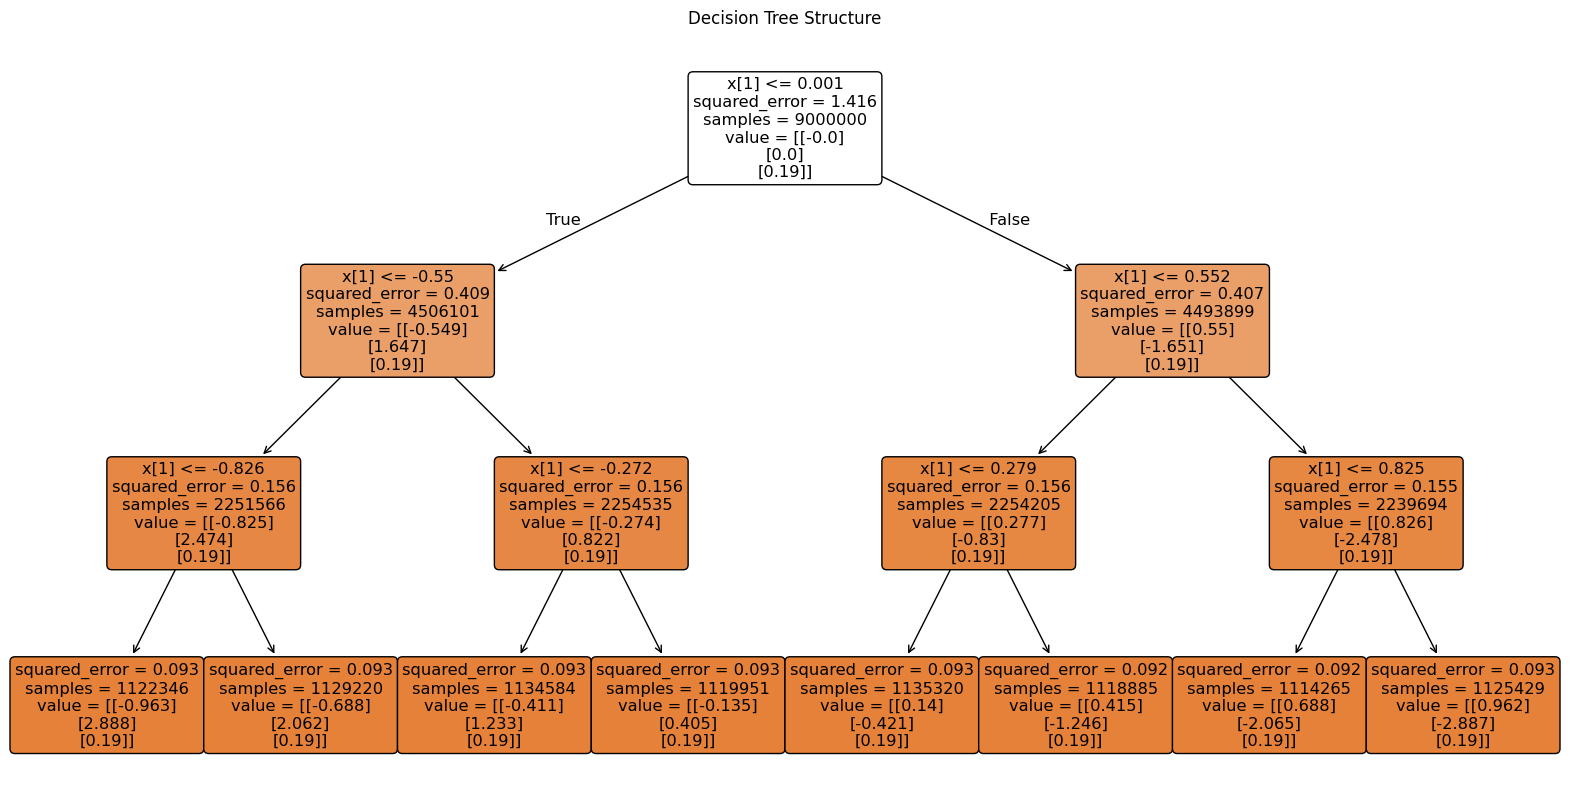

In [14]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=None, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

In [15]:
print("NRMSE [Tree Based] of Training = ", normalized_root_mean_square_error(y_train, tree.predict(X_train)))
print("NRMSE [Tree Based] of Testing  = ", normalized_root_mean_square_error(y_test, tree.predict(X_test)))

NRMSE [Tree Based] of Training =  0.03637093353179778
NRMSE [Tree Based] of Testing  =  0.03638196114029724


In [16]:
# training_samples_at_leaves = get_leaf_samples(tree, X_train)

In [3]:
def least_squares_solution(X_leaf, y_leaf):
    n_samples, n_features = X_leaf.shape
    
    # Step 1: augment X with a column of ones for intercept
    X_aug = np.hstack([np.ones((n_samples, 1)), X_leaf])  # (n × (p+1))
    
    # Step 2: closed-form least squares
    XtX = X_aug.T @ X_aug
    XtY = X_aug.T @ y_leaf
    Theta = np.linalg.pinv(XtX) @ XtY   # use pseudo-inverse for safety
    
    # Step 3: extract intercepts and coefficients
    m0 = Theta[0, :]             # shape (n_outputs,)
    M = Theta[1:, :].T           # shape (n_outputs × n_features)
    
    # Step 4: compute residual sum of squares
    Y_hat = X_aug @ Theta
    residuals = y_leaf - Y_hat
    h_val = np.sum(residuals**2)  # same as before
    
    return M, m0, h_val

In [4]:

def constrained_optimization_regularization_gurobi(X_leaf, y_leaf, lambda_reg=1.0, penalize_bias=False):
    """
    Leaf-wise constrained optimization with L2 regularization.
    
    Args:
        X_leaf: (n_samples, n_features) training data for this leaf
        y_leaf: (n_samples, n_outputs) targets for this leaf
        lambda_reg: float, regularization strength
        penalize_bias: bool, whether to regularize m0 as well as M
    """
    n_samples, n_features = X_leaf.shape
    n_outputs = y_leaf.shape[1]

    # Create model
    model = gp.Model("constrained_optimization")
    model.setParam("OutputFlag", 0)  # silence solver output

    # Decision variables
    M = model.addVars(n_outputs, n_features, lb=-GRB.INFINITY, name="M")
    m0 = model.addVars(n_outputs, lb=-GRB.INFINITY, name="m0")
    h = model.addVar(lb=0, name="h")  # residual bound

    # Compute squared residual sum
    residuals = []
    for i in range(n_samples):
        for k in range(n_outputs):
            expr = gp.LinExpr()
            expr.add(m0[k])
            for j in range(n_features):
                expr.add(M[k, j] * X_leaf[i, j])
            residuals.append((expr - y_leaf[i, k]) * (expr - y_leaf[i, k]))

    # Constraint: sum of squared residuals <= h
    model.addConstr(gp.quicksum(residuals) <= h)

    # Regularization penalty
    reg_penalty = gp.quicksum(M[k, j] * M[k, j] for k in range(n_outputs) for j in range(n_features))
    if penalize_bias:
        reg_penalty += gp.quicksum(m0[k] * m0[k] for k in range(n_outputs))

    # Objective: minimize h + λ * regularization
    model.setObjective(h + lambda_reg * reg_penalty, GRB.MINIMIZE)

    # Optimize
    model.optimize()

    # Extract results
    if model.status == GRB.OPTIMAL:
        M_val = np.array([[M[k, j].X for j in range(n_features)] for k in range(n_outputs)])
        m0_val = np.array([m0[k].X for k in range(n_outputs)])
        h_val = h.X
    else:
        M_val, m0_val, h_val = None, None, np.inf

    return M_val, m0_val, h_val


def constrained_optimization_MSE_regularization_gurobi(X_leaf, y_leaf, lambda_reg=1.0, penalize_bias=False):
    """
    Leaf-wise constrained optimization with L2 regularization and stable MSE constraint.
    
    Args:
        X_leaf: (n_samples, n_features) training data for this leaf
        y_leaf: (n_samples, n_outputs) targets for this leaf
        lambda_reg: float, regularization strength
        penalize_bias: bool, whether to regularize m0 as well as M
    """
    n_samples, n_features = X_leaf.shape
    n_outputs = y_leaf.shape[1]

    # Create model
    model = gp.Model("constrained_optimization")
    model.setParam("OutputFlag", 0)

    # Decision variables
    M = model.addVars(n_outputs, n_features, lb=-GRB.INFINITY, name="M")
    m0 = model.addVars(n_outputs, lb=-GRB.INFINITY, name="m0")
    h = model.addVar(lb=0, name="h")  # MSE upper bound

    # Compute squared residuals
    residuals = []
    for i in range(n_samples):
        for k in range(n_outputs):
            expr = gp.LinExpr()
            expr.add(m0[k])
            for j in range(n_features):
                expr.add(M[k, j] * X_leaf[i, j])
            residuals.append((expr - y_leaf[i, k]) * (expr - y_leaf[i, k]))

    # Stable MSE constraint: sum of squared residuals <= h * n_samples * n_outputs
    model.addConstr(gp.quicksum(residuals) <= h * n_samples * n_outputs)

    # Regularization penalty
    reg_penalty = gp.quicksum(M[k, j] * M[k, j] for k in range(n_outputs) for j in range(n_features))
    if penalize_bias:
        reg_penalty += gp.quicksum(m0[k] * m0[k] for k in range(n_outputs))

    # Objective: minimize h + λ * regularization
    model.setObjective(h + lambda_reg * reg_penalty, GRB.MINIMIZE)

    # Optimize
    model.optimize()

    # Extract results
    if model.status == GRB.OPTIMAL:
        M_val = np.array([[M[k, j].X for j in range(n_features)] for k in range(n_outputs)])
        m0_val = np.array([m0[k].X for k in range(n_outputs)])
        h_val = h.X
    else:
        M_val, m0_val, h_val = None, None, np.inf

    return M_val, m0_val, h_val


In [5]:
def constrained_optimization_MSE_gurobi(X_leaf, y_leaf):
    n_samples, n_features = X_leaf.shape
    n_outputs = y_leaf.shape[1]

    model = gp.Model("constrained_optimization")
    model.setParam("OutputFlag", 0)

    # Variables
    M = model.addVars(n_outputs, n_features, lb=-GRB.INFINITY, name="M")
    m0 = model.addVars(n_outputs, lb=-GRB.INFINITY, name="m0")
    h = model.addVar(lb=0, name="h")  # now represents MSE upper bound

    # Compute squared residuals
    residuals = []
    for i in range(n_samples):
        for k in range(n_outputs):
            expr = gp.LinExpr()
            expr.add(m0[k])
            for j in range(n_features):
                expr.add(M[k, j] * X_leaf[i, j])
            residuals.append((expr - y_leaf[i, k]) * (expr - y_leaf[i, k]))

    # Use mean squared error instead of sum
    mse_expr = gp.quicksum(residuals) / (n_samples * n_outputs)

    # Constraint: mean squared error <= h
    model.addConstr(mse_expr <= h)

    # Objective: minimize h
    model.setObjective(h, GRB.MINIMIZE)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        M_val = np.array([[M[k, j].X for j in range(n_features)] for k in range(n_outputs)])
        m0_val = np.array([m0[k].X for k in range(n_outputs)])
        h_val = h.X
    else:
        M_val, m0_val, h_val = None, None, np.inf

    return M_val, m0_val, h_val


In [19]:
from joblib import Parallel, delayed

def process_leaf(leaf_id, indices, X_train, y_train, feature_names, optimizer):
    X_leaf = X_train[indices]
    y_leaf = y_train[indices]
    
    # Choose optimizer
    if optimizer == "gurobi":
        M, m0, h = constrained_optimization_gurobi(X_leaf, y_leaf)
    elif optimizer == "gurobi_MSE":
        M, m0, h = constrained_optimization_MSE_gurobi(X_leaf, y_leaf)
    elif optimizer == "least_squares":
        M, m0, h = least_squares_solution(X_leaf, y_leaf)
    elif optimizer == "gurobi_l2":
        # print("Optimizing with L2 regularization")
        M, m0, h = constrained_optimization_regularization_gurobi(X_leaf, y_leaf)
    elif optimizer == "gurobi_MSE_l2":
        # print("Optimizing with MSE L2 regularization")
        M, m0, h = constrained_optimization_MSE_regularization_gurobi(X_leaf, y_leaf)
    else:
        M, m0, h = constrained_optimization(X_leaf, y_leaf)
    
    # Build model info
    model = {
        "leaf_id": leaf_id,
        "CO_Model": {'M': M, 'm0': m0, 'h': h},
        "no_samples": len(indices),
        "indices": indices,
        "bounds": {
            feature_names[i]: (X_leaf[:, i].min(), X_leaf[:, i].max())
            for i in range(X_leaf.shape[1])
        }
    }
    return model


def train_COF_on_leaves_parallel(X_train, y_train, tree, feature_names=None, optimizer="gurobi", n_jobs=-1):
    """
    Train constrained optimization models on tree leaves in parallel.

    Parameters:
        X_train, y_train : np.ndarray
        tree : fitted sklearn tree
        feature_names : list of feature names (optional)
        optimizer : {"gurobi", "CVXPY + SCS"}
        n_jobs : number of parallel workers (-1 = all cores)
    """
    leaf_samples = get_leaf_samples(tree, X_train)

    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

    # Run leaf computations in parallel
    tree_extracted_info = Parallel(n_jobs=n_jobs)(
        delayed(process_leaf)(leaf_id, indices, X_train, y_train, feature_names, optimizer)
        for leaf_id, indices in leaf_samples.items()
    )

    return tree_extracted_info


In [15]:
COF_model_tree = train_COF_on_leaves_parallel(X_train, y_train, tree, optimizer="gurobi_MSE", n_jobs=16)


Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter LicenseID to value 2598283
Set parameter Username
Set parameter LicenseID to value 2598283
Set parameter Username
Set parameter LicenseID to value 2598283
Set parameter LicenseID to value 2598283
Set parameter LicenseID to value 2598283
Set parameter LicenseID to value 2598283
Set parameter Username
Set parameter Username
Set parameter LicenseID to value 2598283
Set parameter LicenseID to value 2598283
Academic license - for non-commercial use only - expires 2025-12-11
Academic license - for non-commercial use only - expires 2025-12-11
Academic license - for non-commercial use only - expires 2025-12-11
Academic license - for non-commercial use only - expires 2025-12-11
Academic license - for non-commercial use only - expires 2025-12-11
Academic license - for non-commercial use only - expires 2025-12-11
Academic license - for non-commercial use only - expires 2025-12-11
Academic lic

In [22]:
len(COF_model_tree)


8

In [23]:
high_h = get_h_from_COF(COF_model_tree, greater_then= -np.inf)
high_h




[0.015752738333985238,
 0.01574062805404547,
 0.015751696163084503,
 0.015745416635669352,
 0.015735546606368844,
 0.015745918652985535,
 0.015763988249727145,
 0.015750742897111723]

In [24]:
# high_h = []
# bounds_of_high_h = []
# no_samples_of_high_h = []
# for item in tree_info:
#     print(item['CO_Model']['h'])
#     if item['CO_Model']['h'] > 0.5:
#         high_h.append(item['CO_Model']['h'])
#         bounds_of_high_h.append(item['bounds'])
#         no_samples_of_high_h.append(item['no_samples'])
#         print(item['CO_Model']['h'])
#         print(item['no_samples'])
        
#         print(item['bounds'])
#     print(item)

In [25]:
constraints_on_leaves = get_feature_bounds_from_COF(COF_model_tree)

In [26]:
from Helping_Code import CustomHyperrectangle

In [27]:
customHyperrectangle = CustomHyperrectangle.CustomHyperrectangle()

In [28]:
vertices_of_hyperrectangle = customHyperrectangle.getVerticesFromBounds(constraints_on_leaves)


In [29]:
from Helping_Code.plot import CustomPlotClass
customPlot = CustomPlotClass.CustomPlotClass()


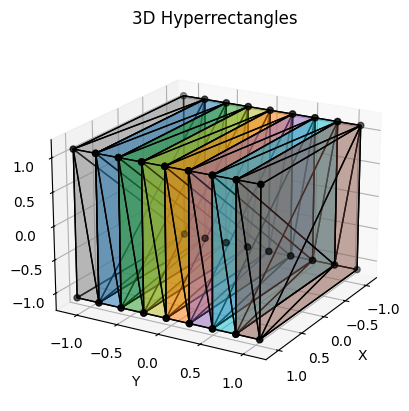

In [30]:
num_cols = constraints_on_leaves.shape[1]

if num_cols == 4:
    # 2D Hyperrectangles
    # customPlot.draw2DHyperrectanglesWithVertices(
    #     vertices_of_polytopes,
    #     title='Constraints as 2D-Rectangles',
    #     dataPoints2D=trajectories_on_leaves
    # )
    customPlot.draw2DHyperrectanglesWithVertices(
        vertices_of_hyperrectangle,
        color='#8f9119'
    )

elif num_cols == 6:
    # 3D Hyperrectangles
    customPlot.draw3DHyperrectanglesWithVertices(
        vertices_of_hyperrectangle,
        interactive=True
    )
else:
    # More than 3D, project into 2D for plotting
    customPlot.drawConstraintsIn2D(
        constraints_on_leaves,
        title='More than 3D Constraints in 2D'
    )

# Compute min and max along each dimension
minOfAllDimensions = np.min(constraints_on_leaves, axis=0)
maxOfAllDimensions = np.max(constraints_on_leaves, axis=0)

In [31]:
X_test[0:2]

array([[ 1.0473266 ,  0.66863877,  0.7537105 ],
       [ 0.32965678, -0.57146657,  0.07072496]])

In [32]:
print(predict_from_COF(COF_model_tree, X_test[0:2], tree))


[[ 0.66875227 -2.68145351  0.18953716]
 [-0.57130968  1.50118774  0.19021584]]


In [33]:
y_test[0:2]

array([[ 0.66863877, -2.6260571 ,  0.50011176],
       [-0.57146657,  1.3922135 ,  0.05384649]])

In [34]:
print("NRMSE [Tree Based] of Training = ", normalized_root_mean_square_error(y_train, predict_from_COF(COF_model_tree, X_train, tree)))
print("NRMSE [Tree Based] of Testing  = ", normalized_root_mean_square_error(y_test, predict_from_COF(COF_model_tree, X_test, tree)))

NRMSE [Tree Based] of Training =  0.01499039772683864
NRMSE [Tree Based] of Testing  =  0.015007925450940613


In [35]:
predict_from_COF(COF_model_tree, vertices_of_hyperrectangle[0], tree)

array([[-0.82544521,  3.18592483,  0.18951509],
       [-0.82544521,  1.76685382,  0.18966237],
       [-0.5493625 ,  2.35768332,  0.19013681],
       [-0.5493625 ,  0.93861231,  0.19028409],
       [-0.82544521,  3.18562124,  0.18957664],
       [-0.82544521,  1.76655023,  0.18972392],
       [-0.5493625 ,  2.35737973,  0.19019835],
       [-0.5493625 ,  0.93830872,  0.19034563]])

In [36]:
elevated_vertices = get_elevated_vertices(COF_model_tree, vertices_of_hyperrectangle)

In [37]:
vertices_of_hyperrectangle[0]

array([[-1.0999986, -0.8256761, -1.0999988],
       [ 1.0999986, -0.8256761, -1.0999988],
       [-1.0999986, -0.549513 , -1.0999988],
       [ 1.0999986, -0.549513 , -1.0999988],
       [-1.0999986, -0.8256761,  1.0999982],
       [ 1.0999986, -0.8256761,  1.0999982],
       [-1.0999986, -0.549513 ,  1.0999982],
       [ 1.0999986, -0.549513 ,  1.0999982]])

In [38]:
elevated_vertices[0]

array([[-0.82544521,  3.18592483,  0.18951509],
       [-0.82544521,  1.76685382,  0.18966237],
       [-0.5493625 ,  2.35768332,  0.19013681],
       [-0.5493625 ,  0.93861231,  0.19028409],
       [-0.82544521,  3.18562124,  0.18957664],
       [-0.82544521,  1.76655023,  0.18972392],
       [-0.5493625 ,  2.35737973,  0.19019835],
       [-0.5493625 ,  0.93830872,  0.19034563]])

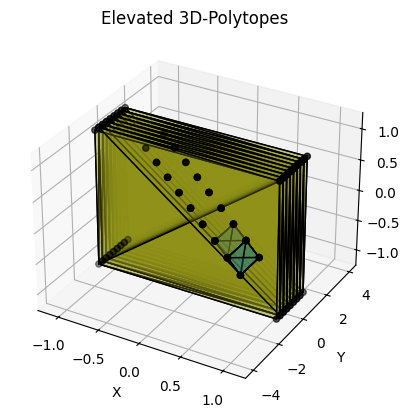

In [39]:
# Check the number of rows in the first element of vertices_of_elevated_polytopes_before_span
dim = elevated_vertices[0].shape[0]

if dim == 4:
    # 2D polytopes
    customPlot.drawDual2DHyperrectanglesWithVertices(
        vertices_of_hyperrectangle,
        elevated_vertices,
        color1='#8f9119',
        color2='#197b91',
        title='Elevated 2D-Polytopes'
    )
elif dim == 8:
    # 3D polytopes
    customPlot.drawDual3DHyperrectanglesWithVertices(
        vertices_of_hyperrectangle,
        elevated_vertices,
        color1='#8f9119',
        color2='#197b91',
        title='Elevated 3D-Polytopes'
    )
else:
    # Fallback for other cases
    customPlot.drawDual2DHyperrectanglesWithVertices(
        vertices_of_hyperrectangle,
        elevated_vertices,
        title='More than 3D Polytopes in 2D'
    )


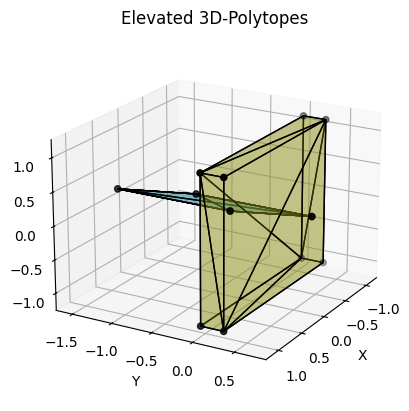

In [40]:
customPlot.drawDual3DHyperrectanglesWithVertices(
        [vertices_of_hyperrectangle[1]],
        [elevated_vertices[1]],
        color1='#8f9119',
        color2='#197b91',
        title='Elevated 3D-Polytopes',
        interactive=True
    )

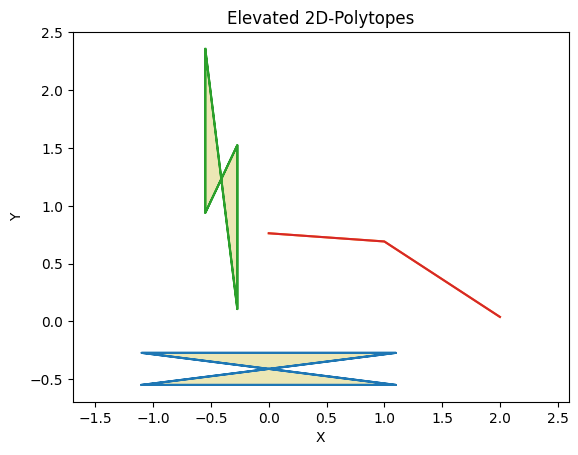

In [41]:
customPlot.drawDual2DHyperrectanglesWithVertices(
        [vertices_of_hyperrectangle[2]],
        [elevated_vertices[2]],
        color1='#8f9119',
        color2='#197b91',
        title='Elevated 2D-Polytopes'
    )

In [42]:

state_graph_transition_matrix = np.zeros((numLeaves , numLeaves ))  


for i in range(numLeaves):
    local_row = np.zeros(numLeaves)  # Initialize local row
    h = COF_model_tree[i]['CO_Model']['h']
    for j in range(numLeaves):
        vertices_P1 = elevated_vertices[i]
        vertices_P2 = vertices_of_hyperrectangle[j]

        # Call the distance function
        _, _, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(vertices_P1, vertices_P2)

        if min_distance < h:
            local_row[j] = 1  # Assign transition state
    # print(local_row)
    state_graph_transition_matrix[i, :] = local_row


In [43]:
state_graph_transition_matrix

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 0., 1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0.]])

In [44]:
def create_automaton_from_matrix(T):
    n_states = T.shape[0]
    automaton = {}
    for i in range(n_states):
        automaton[i] = []
        for j in range(T.shape[1]):
            if T[i, j] != 0:
                automaton[i].append(j)
    return automaton

automaton = create_automaton_from_matrix(state_graph_transition_matrix)
print(automaton)


{0: [4], 1: [0, 1, 2, 3, 5, 6, 7], 2: [1, 3, 4, 7], 3: [0, 2, 5, 6], 4: [], 5: [], 6: [0, 1, 2, 3, 4, 6, 7], 7: [5]}


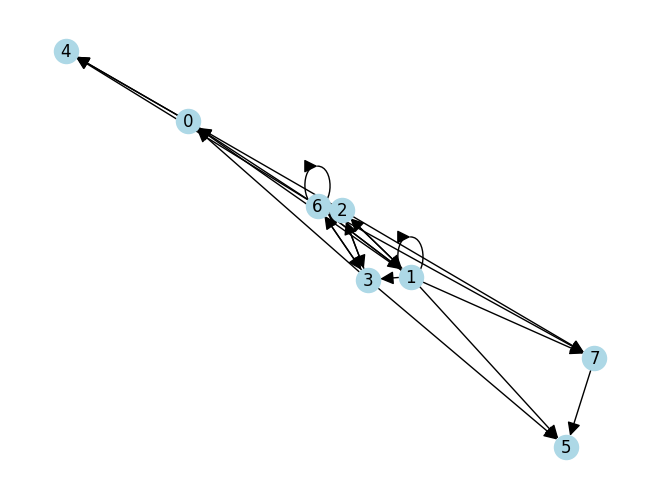

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for state, next_states in automaton.items():
    for next_state in next_states:
        G.add_edge(state, next_state)

nx.draw(G, with_labels=True, node_color='lightblue', arrowsize=20)
plt.show()

In [47]:
import networkx as nx
from pyvis.network import Network

# Example automaton
# automaton = {0: [1], 1: [2], 2: [0]}

G = nx.DiGraph()
for state, next_states in automaton.items():
    for next_state in next_states:
        G.add_edge(state, next_state)

# Create interactive network
net = Network(height='500px', width='800px', directed=True)
net.from_nx(G)
net.show("automaton.html")


automaton.html


AttributeError: 'NoneType' object has no attribute 'render'

In [51]:
state_graph_transition_matrix

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 1., 0., 1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0.]])

In [66]:
import numpy as np
import networkx as nx
from bokeh.plotting import figure, show
from bokeh.models import GraphRenderer, StaticLayoutProvider, Circle, MultiLine

# State transition matrix
T = state_graph_transition_matrix

n_states = T.shape[0]

# Create directed graph
G = nx.DiGraph()
for i in range(n_states):
    for j in range(n_states):
        if T[i, j] != 0:
            G.add_edge(i, j)

# Keep only nodes that appear in edges
active_nodes = set([n for edge in G.edges for n in edge])

# Graph renderer
graph = GraphRenderer()
graph.node_renderer.data_source.add(list(active_nodes), 'index')
graph.node_renderer.glyph = Circle(radius=0.1, fill_color='lightblue')
graph.node_renderer.selection_glyph = Circle(radius=0.12, fill_color='orange')
graph.node_renderer.hover_glyph = Circle(radius=0.12, fill_color='green')

graph.edge_renderer.data_source.data = dict(
    start=[i[0] for i in G.edges()],
    end=[i[1] for i in G.edges()]
)
graph.edge_renderer.glyph = MultiLine(line_color="black", line_width=2)

# Circular layout only for active nodes
angles = np.linspace(0, 2*np.pi, len(active_nodes), endpoint=False)
x = np.cos(angles)
y = np.sin(angles)
graph.layout_provider = StaticLayoutProvider(
    graph_layout={node: (x[idx], y[idx]) for idx, node in enumerate(active_nodes)}
)

# Plot
plot = figure(title="Interactive Automaton", x_range=(-1.5, 1.5), y_range=(-1.5, 1.5),
              tools="pan,wheel_zoom,reset,save", width=700, height=700)
plot.renderers.append(graph)

show(plot)


In [58]:
from bokeh.plotting import figure, show
from bokeh.models import GraphRenderer, StaticLayoutProvider, Circle, MultiLine
import networkx as nx

# Example graph
G = nx.DiGraph()
G.add_edges_from([(0,1), (1,2), (2,0)])

# Create graph renderer
graph = GraphRenderer()

# Node data
graph.node_renderer.data_source.add(list(G.nodes), 'index')
graph.node_renderer.glyph = Circle(radius=0.1, fill_color='lightblue')  # <-- use radius instead of size
graph.node_renderer.selection_glyph = Circle(radius=0.12, fill_color='orange')
graph.node_renderer.hover_glyph = Circle(radius=0.12, fill_color='green')

# Edge data
graph.edge_renderer.data_source.data = dict(
    start=[i[0] for i in G.edges()],
    end=[i[1] for i in G.edges()]
)
graph.edge_renderer.glyph = MultiLine(line_color="black", line_width=2)

# Layout
x = [i for i in G.nodes()]
y = [0 for _ in G.nodes()]
graph.layout_provider = StaticLayoutProvider(graph_layout={i:(x[i], y[i]) for i in G.nodes()})

# Figure
plot = figure(title="Interactive Automaton", x_range=(-1, 3), y_range=(-1, 2),
              tools="pan,wheel_zoom,reset,save")
plot.renderers.append(graph)

show(plot)


In [49]:
customHyperrectangle.minimize_hyperrectangle_distance_dual(elevated_vertices[0], vertices_of_hyperrectangle[0])

(array([-0.06915246, -0.10520176,  0.17955806]),
 array([-0.06915419, -0.10520106,  0.17955552]),
 np.float64(3.1526658052824836e-06))

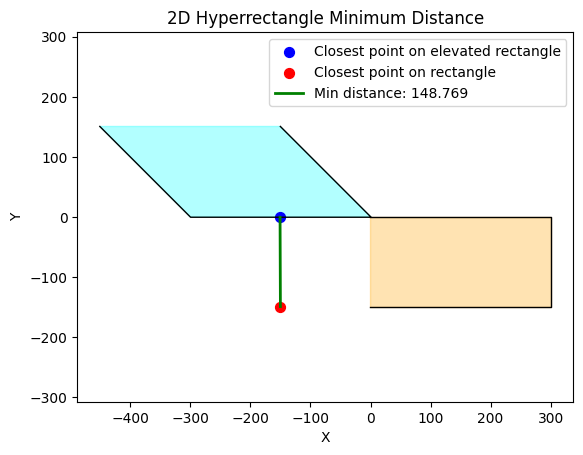

In [258]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# Get closest points and distance
X_opt, Xp_opt, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(
    elevated_vertices[0], vertices_of_hyperrectangle[1]
)

# Determine dimension
dim = elevated_vertices[0].shape[1]

if dim == 2:
    # 2D plotting
    plt.figure()
    
    def plot_2d_hyperrectangle(vertices, color='cyan', alpha=0.3):
        from scipy.spatial import ConvexHull
        hull = ConvexHull(vertices)
        plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color=color, alpha=alpha)
        plt.plot(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'k-', linewidth=1)
    
    # Plot rectangles
    plot_2d_hyperrectangle(elevated_vertices[0], color='cyan', alpha=0.3)
    plot_2d_hyperrectangle(vertices_of_hyperrectangle[0], color='orange', alpha=0.3)
    
    # Plot closest points
    plt.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated rectangle')
    plt.scatter(*Xp_opt, color='red', s=50, label='Closest point on rectangle')
    
    # Draw line connecting closest points
    plt.plot([X_opt[0], Xp_opt[0]], [X_opt[1], Xp_opt[1]], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Hyperrectangle Minimum Distance')
    plt.legend()
    plt.axis('equal')
    plt.show()
    
else:
    # 3D plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    def plot_3d_hyperrectangle(ax, verts, color='cyan', alpha=0.3):
        faces = np.array([[0, 1, 3, 2], [0, 1, 5, 4], [0, 2, 6, 4],
                          [1, 3, 7, 5], [2, 3, 7, 6], [4, 5, 7, 6]])
        poly3d = [[verts[idx] for idx in face] for face in faces]
        ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='k', alpha=alpha))
    
    # Plot hyperrectangles
    plot_3d_hyperrectangle(ax, elevated_vertices[0], color='cyan', alpha=0.3)
    plot_3d_hyperrectangle(ax, vertices_of_hyperrectangle[0], color='orange', alpha=0.3)
    
    # Plot closest points
    ax.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated hyperrectangle')
    ax.scatter(*Xp_opt, color='red', s=50, label='Closest point on hyperrectangle')
    
    # Draw line connecting closest points
    line_pts = np.vstack([X_opt, Xp_opt])
    ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title('3D Hyperrectangle Minimum Distance')
    ax.legend()
    plt.show()


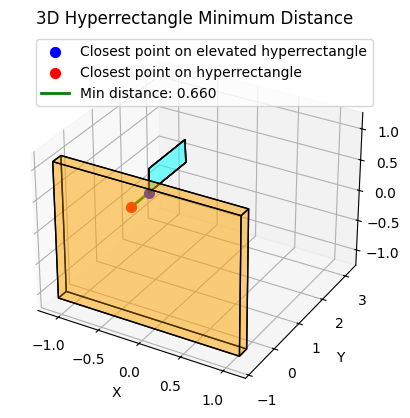

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

# Get closest points and distance
X_opt, Xp_opt, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(
    elevated_vertices[0], vertices_of_hyperrectangle[1]
)

# Determine dimension
dim = elevated_vertices[0].shape[1]

if dim == 2:
    # 2D plotting
    plt.figure()
    
    def plot_2d_hyperrectangle(vertices, color='cyan', alpha=0.3):
        from scipy.spatial import ConvexHull
        hull = ConvexHull(vertices)
        plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color=color, alpha=alpha)
        plt.plot(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'k-', linewidth=1)
    
    # Plot rectangles
    plot_2d_hyperrectangle(elevated_vertices[0], color='cyan', alpha=0.3)
    plot_2d_hyperrectangle(vertices_of_hyperrectangle[0], color='orange', alpha=0.3)
    
    # Plot closest points
    plt.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated rectangle')
    plt.scatter(*Xp_opt, color='red', s=50, label='Closest point on rectangle')
    
    # Draw line connecting closest points
    plt.plot([X_opt[0], Xp_opt[0]], [X_opt[1], Xp_opt[1]], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Hyperrectangle Minimum Distance')
    plt.legend()
    plt.axis('equal')
    plt.show()
    
else:
    # 3D plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    def plot_3d_hyperrectangle(ax, verts, color='cyan', alpha=0.3):
        faces = np.array([[0, 1, 3, 2], [0, 1, 5, 4], [0, 2, 6, 4],
                          [1, 3, 7, 5], [2, 3, 7, 6], [4, 5, 7, 6]])
        poly3d = [[verts[idx] for idx in face] for face in faces]
        ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='k', alpha=alpha))
    
    # Plot hyperrectangles
    plot_3d_hyperrectangle(ax, elevated_vertices[0], color='cyan', alpha=0.3)
    plot_3d_hyperrectangle(ax, vertices_of_hyperrectangle[0], color='orange', alpha=0.3)
    
    # Plot closest points
    ax.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated hyperrectangle')
    ax.scatter(*Xp_opt, color='red', s=50, label='Closest point on hyperrectangle')
    
    # Draw line connecting closest points
    line_pts = np.vstack([X_opt, Xp_opt])
    ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title('3D Hyperrectangle Minimum Distance')
    ax.legend()
    plt.show()


In [130]:
list (tree_info[0]['bounds']['feature_0'])

[np.float64(-300.09995), np.float64(300.1)]

# From Here Comparison get Started

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import itertools

import json
import os

import networkx as nx

import random

from joblib import Parallel, delayed

import logging

from sklearn.decomposition import PCA

In [64]:
%load_ext autoreload
%autoreload 2
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
from benchmark import generate_save_benchmark_dataset
from QuadraticConstraintModel import train_COF_on_leaves, get_h_from_COF

from QuadraticConstraintModel import get_feature_bounds_from_COF, predict_from_COF, get_elevated_vertices

from QuadraticConstraintModel import get_leaf_samples

from QuadraticConstraintModel import gurobi_minimax, cvxpy_minimax

In [88]:
from Helping_Code import CustomHyperrectangle
from Helping_Code.plot import CustomPlotClass

customHyperrectangle = CustomHyperrectangle.CustomHyperrectangle()
customPlot = CustomPlotClass.CustomPlotClass()

In [89]:
def normalized_root_mean_square_error(y_true, y_pred):
    """
    Computes the Normalized Root Mean Square Error (NRMSE) between y_true and y_pred.
    If the range of y_true is zero, it normalizes by the number of samples * outputs.

    Parameters:
        y_true (np.ndarray): Ground truth values, shape (n_samples, n_outputs)
        y_pred (np.ndarray): Predicted values, shape (n_samples, n_outputs)

    Returns:
        float: NRMSE value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Compute range
    y_range = np.max(y_true) - np.min(y_true)
    
    if y_range != 0:
        # Normalize by range
        return rmse / y_range
    else:
        # Normalize by n_samples * n_outputs
        n_samples, n_outputs = y_true.shape
        return np.sqrt(np.sum((y_true - y_pred) ** 2) / (n_samples * n_outputs))


# Convert all numpy arrays to lists before dumping
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj



In [90]:
from joblib import Parallel, delayed

def process_leaf(leaf_id, indices, X_train, y_train, feature_names, optimizer):
    X_leaf = X_train[indices]
    y_leaf = y_train[indices]

    if X_leaf.shape[0] == 0:
        return None, None, np.inf
    
    # Choose optimizer
    if optimizer == "gurobi":
        M, m0, h = gurobi_minimax(X_leaf, y_leaf)
    else:
        M, m0, h = cvxpy_minimax(X_leaf, y_leaf, squared=True)
    
    # Build model info
    model = {
        "leaf_id": leaf_id,
        "CO_Model": {'M': M, 'm0': m0, 'h': h},
        "no_samples": len(indices),
        "indices": indices,
        "bounds": {
            feature_names[i]: (X_leaf[:, i].min(), X_leaf[:, i].max())
            for i in range(X_leaf.shape[1])
        }
    }
    return model


def train_COF_on_leaves_parallel(X_train, y_train, tree, feature_names=None, optimizer="gurobi", n_jobs=-1):
    """
    Train constrained optimization models on tree leaves in parallel.

    Parameters:
        X_train, y_train : np.ndarray
        tree : fitted sklearn tree
        feature_names : list of feature names (optional)
        optimizer : {"gurobi", "CVXPY + SCS"}
        n_jobs : number of parallel workers (-1 = all cores)
    """
    leaf_samples = get_leaf_samples(tree, X_train)

    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

    # Run leaf computations in parallel
    tree_extracted_info = Parallel(n_jobs=n_jobs)(
        delayed(process_leaf)(leaf_id, indices, X_train, y_train, feature_names, optimizer)
        for leaf_id, indices in leaf_samples.items()
    )

    return tree_extracted_info


In [74]:
def plotHyperrectanglesOfStateSpace(vertices_of_hyperrectangle, title="partitions of state space", savePath=None):
    num_of_vertices = vertices_of_hyperrectangle[0].shape[0]
    # print(f"number of vertices = {num_of_vertices}")
    if num_of_vertices == 4:
        customPlot.draw2DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            color='#8f9119',
            title=title,
            savePath=savePath
        )

    elif num_of_vertices == 8:
        # 3D Hyperrectangles
        customPlot.draw3DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            interactive=True,
            title=title,
            savePath=savePath
        )
    else:
        # Higher-dimensional hyperrectangles → reduce to 3D using PCA
        projected_vertices = []
        for verts in vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            projected_vertices.append(verts_reduced)

        customPlot.draw3DHyperrectanglesWithVertices(
            projected_vertices,
            interactive=True,
            title=title,
            savePath=savePath
        )


def plotElivatedHyperrectangles(vertices_of_hyperrectangle, elevated_vertices_of_hyperrectangle, title="Elevated Hyper Rectangles", savePath=None):
    num_of_vertices = vertices_of_hyperrectangle[0].shape[0]

    if num_of_vertices == 4:
        # 2D polytopes
        customPlot.drawDual2DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            elevated_vertices_of_hyperrectangle,
            color1='#8f9119',
            color2='#197b91',
            title=title,
            savePath=savePath
        )
    elif num_of_vertices == 8:
        # 3D polytopes
        customPlot.drawDual3DHyperrectanglesWithVertices(
            vertices_of_hyperrectangle,
            elevated_vertices_of_hyperrectangle,
            color1='#8f9119',
            color2='#197b91',
            title=title,
            savePath=savePath
        )
    else:
        # Higher-dimensional hyperrectangles → reduce to 3D using PCA
        projected_vertices = []
        for verts in vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            projected_vertices.append(verts_reduced)

        elevated_projected_vertices = []
        for verts in elevated_vertices_of_hyperrectangle:
            pca = PCA(n_components=3)
            verts_reduced = pca.fit_transform(verts)
            elevated_projected_vertices.append(verts_reduced)

        
        # Fallback for other cases
        customPlot.drawDual2DHyperrectanglesWithVertices(
            projected_vertices,
            elevated_projected_vertices,
            title=title,
            savePath=savePath
        )



def plotDistanceBetweenTwoHyperrectangles(elevated_vertices, vertices_of_hyperrectangle, savePath="", title="Hyperrectangle Minimum Distance"):
    
    # Get closest points and distance
    X_opt, Xp_opt, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(
        elevated_vertices, vertices_of_hyperrectangle
    )
    
    # Determine dimension
    dim = elevated_vertices.shape[1]
    
    if dim == 2:
        # 2D plotting
        plt.figure()
        
        def plot_2d_hyperrectangle(vertices, color='cyan', alpha=0.3):
            from scipy.spatial import ConvexHull
            hull = ConvexHull(vertices)
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color=color, alpha=alpha)
            plt.plot(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'k-', linewidth=1)
        
        # Plot rectangles
        plot_2d_hyperrectangle(elevated_vertices, color='cyan', alpha=0.3)
        plot_2d_hyperrectangle(vertices_of_hyperrectangle, color='orange', alpha=0.3)
        
        # Plot closest points
        plt.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated rectangle')
        plt.scatter(*Xp_opt, color='red', s=50, label='Closest point on rectangle')
        
        # Draw line connecting closest points
        plt.plot([X_opt[0], Xp_opt[0]], [X_opt[1], Xp_opt[1]], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
        
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.legend()
        plt.axis('equal')
        plt.savefig(savePath)
        plt.show()
        
    else:
        # 3D plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        def plot_3d_hyperrectangle(ax, verts, color='cyan', alpha=0.3):
            faces = np.array([[0, 1, 3, 2], [0, 1, 5, 4], [0, 2, 6, 4],
                              [1, 3, 7, 5], [2, 3, 7, 6], [4, 5, 7, 6]])
            poly3d = [[verts[idx] for idx in face] for face in faces]
            ax.add_collection3d(Poly3DCollection(poly3d, facecolors=color, linewidths=1, edgecolors='k', alpha=alpha))
        
        # Plot hyperrectangles
        plot_3d_hyperrectangle(ax, elevated_vertices, color='cyan', alpha=0.3)
        plot_3d_hyperrectangle(ax, vertices_of_hyperrectangle, color='orange', alpha=0.3)
        
        # Plot closest points
        ax.scatter(*X_opt, color='blue', s=50, label='Closest point on elevated hyperrectangle')
        ax.scatter(*Xp_opt, color='red', s=50, label='Closest point on hyperrectangle')
        
        # Draw line connecting closest points
        line_pts = np.vstack([X_opt, Xp_opt])
        ax.plot(line_pts[:,0], line_pts[:,1], line_pts[:,2], color='green', linewidth=2, label=f'Min distance: {min_distance:.3f}')
        
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(title)
        ax.legend()
        plt.savefig(savePath)
        plt.show()
    


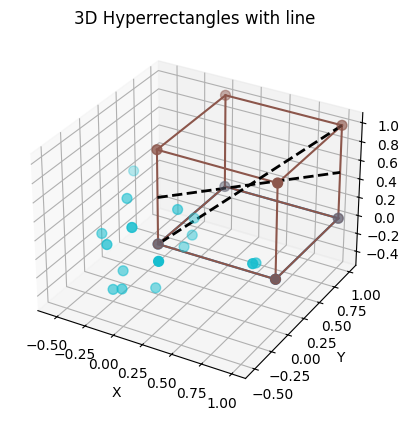

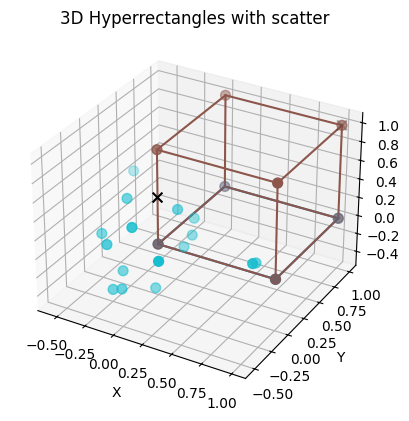

In [75]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import matplotlib

# def plot_hyperrectangles(list_of_vertices):
#     # Determine maximum dimension to choose 2D or 3D plot
#     max_dim = max(vertices.shape[1] for vertices in list_of_vertices)
#     plot_dim = 3 if max_dim > 3 else max_dim
    
#     # Set up plot
#     if plot_dim == 2:
#         fig, ax = plt.subplots()
#     else:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
    
#     colors = matplotlib.colormaps['tab10'].resampled(len(list_of_vertices))
    
#     for idx, vertices in enumerate(list_of_vertices):
#         n_vertices, n_dims = vertices.shape
        
#         # Degenerate case: single point
#         if n_vertices == 1:
#             if plot_dim == 2:
#                 ax.scatter(vertices[0,0], vertices[0,1], c=[colors(idx)], s=100)
#             else:
#                 z = vertices[0,2] if n_dims >=3 else 0
#                 ax.scatter(vertices[0,0], vertices[0,1], z, c=[colors(idx)], s=100)
#             continue
        
#         # Reduce dimension if necessary
#         if n_dims > 3:
#             pca = PCA(n_components=3)
#             vertices_plot = pca.fit_transform(vertices)
#         else:
#             vertices_plot = vertices
        
#         # Pad to 3D if needed
#         if vertices_plot.shape[1] < 3:
#             pad_width = 3 - vertices_plot.shape[1]
#             vertices_plot = np.hstack([vertices_plot, np.zeros((vertices_plot.shape[0], pad_width))])
        
#         # 2D plot
#         if plot_dim == 2:
#             x, y = vertices_plot[:,0], vertices_plot[:,1]
#             ax.scatter(x, y, c=[colors(idx)]*len(x))
#             for i in range(n_vertices):
#                 for j in range(i+1, n_vertices):
#                     if np.sum(np.abs(vertices[i]-vertices[j]) > 1e-8) == 1:
#                         ax.plot([vertices[i,0], vertices[j,0]], [vertices[i,1], vertices[j,1]], c=colors(idx))
#         # 3D plot
#         else:
#             x, y, z = vertices_plot[:,0], vertices_plot[:,1], vertices_plot[:,2]
#             ax.scatter(x, y, z, c=[colors(idx)]*len(x), s=50)
#             for i in range(n_vertices):
#                 for j in range(i+1, n_vertices):
#                     if np.sum(np.abs(vertices[i]-vertices[j]) > 1e-8) == 1:
#                         xi, yi, zi = vertices_plot[i]
#                         xj, yj, zj = vertices_plot[j]
#                         ax.plot([xi, xj], [yi, yj], [zi, zj], c=colors(idx))
    
#     # Set labels
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     if plot_dim == 3:
#         ax.set_zlabel('Z')
#     ax.set_title(f"{plot_dim}D Hyperrectangles")
#     plt.show()


# # Example usage
# rect2d = np.array([[0,0],[1,0],[1,1],[0,1]])
# rect2d2 = np.array([[0.5,0],[1,0],[1,1.5],[0,1]])
# rect3d = np.array([[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]])
# rect5d = np.random.rand(16,5)  # 5D hyperrectangle

# plot_hyperrectangles([rect2d, rect2d2])


# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import matplotlib

# def plot_hyperrectangles(list_of_vertices, X_lines=None, y_lines=None):
#     """
#     Plots hyperrectangles and optional lines.
    
#     Parameters:
#         list_of_vertices (list of np.ndarray): Each element is an array of shape (n_vertices, n_dimensions)
#         X_lines (np.ndarray or list): Array of shape (n_lines, n_dims) containing line start points
#         y_lines (np.ndarray or list): Array of shape (n_lines, n_dims) containing line end points
#     """
    
#     # Determine maximum dimension among all hyperrectangles and lines
#     max_dim = max(vertices.shape[1] for vertices in list_of_vertices)
#     if X_lines is not None and y_lines is not None:
#         max_dim = max(max_dim, X_lines.shape[1], y_lines.shape[1])
    
#     plot_dim = 3 if max_dim > 3 else max_dim
    
#     # Set up plot
#     if plot_dim == 2:
#         fig, ax = plt.subplots()
#     else:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
    
#     colors = matplotlib.colormaps['tab10'].resampled(len(list_of_vertices))
    
#     # Plot hyperrectangles
#     for idx, vertices in enumerate(list_of_vertices):
#         n_vertices, n_dims = vertices.shape
        
#         # Degenerate case: single point
#         if n_vertices == 1:
#             if plot_dim == 2:
#                 ax.scatter(vertices[0,0], vertices[0,1], c=[colors(idx)], s=100)
#             else:
#                 z = vertices[0,2] if n_dims >=3 else 0
#                 ax.scatter(vertices[0,0], vertices[0,1], z, c=[colors(idx)], s=100)
#             continue
        
#         # Reduce dimension if necessary
#         if n_dims > 3:
#             pca = PCA(n_components=3)
#             vertices_plot = pca.fit_transform(vertices)
#         else:
#             vertices_plot = vertices
        
#         # Pad to 3D if needed
#         if vertices_plot.shape[1] < 3:
#             pad_width = 3 - vertices_plot.shape[1]
#             vertices_plot = np.hstack([vertices_plot, np.zeros((vertices_plot.shape[0], pad_width))])
        
#         # 2D plot
#         if plot_dim == 2:
#             x, y = vertices_plot[:,0], vertices_plot[:,1]
#             ax.scatter(x, y, c=[colors(idx)]*len(x))
#             # Connect edges
#             for i in range(n_vertices):
#                 for j in range(i+1, n_vertices):
#                     if np.sum(np.abs(vertices[i]-vertices[j]) > 1e-8) == 1:
#                         ax.plot([vertices[i,0], vertices[j,0]], [vertices[i,1], vertices[j,1]], c=colors(idx))
#         # 3D plot
#         else:
#             x, y, z = vertices_plot[:,0], vertices_plot[:,1], vertices_plot[:,2]
#             ax.scatter(x, y, z, c=[colors(idx)]*len(x), s=50)
#             # Connect edges
#             for i in range(n_vertices):
#                 for j in range(i+1, n_vertices):
#                     if np.sum(np.abs(vertices[i]-vertices[j]) > 1e-8) == 1:
#                         xi, yi, zi = vertices_plot[i]
#                         xj, yj, zj = vertices_plot[j]
#                         ax.plot([xi, xj], [yi, yj], [zi, zj], c=colors(idx))
    
#     # Plot additional lines
#     if X_lines is not None and y_lines is not None:
#         X_lines = np.array(X_lines)
#         y_lines = np.array(y_lines)
        
#         # Reduce dimension if needed
#         if X_lines.shape[1] > 3:
#             pca = PCA(n_components=3)
#             all_points = np.vstack([X_lines, y_lines])
#             all_points_3d = pca.fit_transform(all_points)
#             X_lines_plot = all_points_3d[:len(X_lines)]
#             y_lines_plot = all_points_3d[len(X_lines):]
#         else:
#             X_lines_plot = X_lines
#             y_lines_plot = y_lines
        
#         # Pad to 3D if needed
#         if X_lines_plot.shape[1] < 3:
#             pad_width = 3 - X_lines_plot.shape[1]
#             X_lines_plot = np.hstack([X_lines_plot, np.zeros((X_lines_plot.shape[0], pad_width))])
#             y_lines_plot = np.hstack([y_lines_plot, np.zeros((y_lines_plot.shape[0], pad_width))])
        
#         # Draw lines
#         for start, end in zip(X_lines_plot, y_lines_plot):
#             ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 'k--', linewidth=2)

        
    
#     # Set labels
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     if plot_dim == 3:
#         ax.set_zlabel('Z')
#     ax.set_title(f"{plot_dim}D Hyperrectangles with Lines")
#     plt.show()


# # Example usage
# rect2d = np.array([[0,0],[1,0],[1,1],[0,1]])
# rect3d = np.array([[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]])
# rect5d = np.random.rand(16,5)  # 5D hyperrectangle

# # Lines
# X_lines = np.array([[0,0, 0],[1,1, 1]])
# y_lines = np.array([[1,1, 0.5],[0,0, 0.5]])

# plot_hyperrectangles([rect2d, rect3d, rect5d], X_lines, y_lines)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib

def plot_hyperrectangles(list_of_vertices, X_lines=None, y_lines=None, line_style='line'):
    """
    Plots hyperrectangles and optional lines or scatter points.
    
    Parameters:
        list_of_vertices (list of np.ndarray): Each element is an array of shape (n_vertices, n_dimensions)
        X_lines (np.ndarray or list): Array of shape (n_lines, n_dims) containing line start points
        y_lines (np.ndarray or list): Array of shape (n_lines, n_dims) containing line end points
        line_style (str): 'line' to draw lines between X and y, 'scatter' to just plot X points
    """
    
    # Determine maximum dimension among all hyperrectangles and lines
    max_dim = max(vertices.shape[1] for vertices in list_of_vertices)
    if X_lines is not None and y_lines is not None:
        max_dim = max(max_dim, X_lines.shape[1], y_lines.shape[1])
    
    plot_dim = 3 if max_dim > 3 else max_dim
    
    # Set up plot
    if plot_dim == 2:
        fig, ax = plt.subplots()
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    
    colors = matplotlib.colormaps['tab10'].resampled(len(list_of_vertices))
    
    # Plot hyperrectangles
    for idx, vertices in enumerate(list_of_vertices):
        n_vertices, n_dims = vertices.shape
        
        # Degenerate case: single point
        if n_vertices == 1:
            if plot_dim == 2:
                ax.scatter(vertices[0,0], vertices[0,1], c=[colors(idx)], s=100)
            else:
                z = vertices[0,2] if n_dims >=3 else 0
                ax.scatter(vertices[0,0], vertices[0,1], z, c=[colors(idx)], s=100)
            continue
        
        # Reduce dimension if necessary
        if n_dims > 3:
            pca = PCA(n_components=3)
            vertices_plot = pca.fit_transform(vertices)
        else:
            vertices_plot = vertices
        
        # Pad to 3D if needed
        if vertices_plot.shape[1] < 3:
            pad_width = 3 - vertices_plot.shape[1]
            vertices_plot = np.hstack([vertices_plot, np.zeros((vertices_plot.shape[0], pad_width))])
        
        # 2D plot
        if plot_dim == 2:
            x, y = vertices_plot[:,0], vertices_plot[:,1]
            ax.scatter(x, y, c=[colors(idx)]*len(x))
            # Connect edges
            for i in range(n_vertices):
                for j in range(i+1, n_vertices):
                    if np.sum(np.abs(vertices[i]-vertices[j]) > 1e-8) == 1:
                        ax.plot([vertices[i,0], vertices[j,0]], [vertices[i,1], vertices[j,1]], c=colors(idx))
        # 3D plot
        else:
            x, y, z = vertices_plot[:,0], vertices_plot[:,1], vertices_plot[:,2]
            ax.scatter(x, y, z, c=[colors(idx)]*len(x), s=50)
            # Connect edges
            for i in range(n_vertices):
                for j in range(i+1, n_vertices):
                    if np.sum(np.abs(vertices[i]-vertices[j]) > 1e-8) == 1:
                        xi, yi, zi = vertices_plot[i]
                        xj, yj, zj = vertices_plot[j]
                        ax.plot([xi, xj], [yi, yj], [zi, zj], c=colors(idx))
    
    # Plot additional lines or scatter points
    if X_lines is not None:
        X_lines = np.array(X_lines)
        if line_style == 'scatter':
            # Reduce dimension if needed
            if X_lines.shape[1] > 3:
                pca = PCA(n_components=3)
                X_plot = pca.fit_transform(X_lines)
            else:
                X_plot = X_lines
            # Pad to 3D
            if X_plot.shape[1] < 3:
                pad_width = 3 - X_plot.shape[1]
                X_plot = np.hstack([X_plot, np.zeros((X_plot.shape[0], pad_width))])
            # Plot points
            if plot_dim == 2:
                ax.scatter(X_plot[:,0], X_plot[:,1], c='k', marker='x', s=50, label='X points')
            else:
                ax.scatter(X_plot[:,0], X_plot[:,1], X_plot[:,2], c='k', marker='x', s=50, label='X points')
        
        elif line_style == 'line' and y_lines is not None:
            y_lines = np.array(y_lines)
            # Reduce dimension if needed
            if X_lines.shape[1] > 3:
                pca = PCA(n_components=3)
                all_points = np.vstack([X_lines, y_lines])
                all_points_3d = pca.fit_transform(all_points)
                X_lines_plot = all_points_3d[:len(X_lines)]
                y_lines_plot = all_points_3d[len(X_lines):]
            else:
                X_lines_plot = X_lines
                y_lines_plot = y_lines
            
            # Pad to 3D
            if X_lines_plot.shape[1] < 3:
                pad_width = 3 - X_lines_plot.shape[1]
                X_lines_plot = np.hstack([X_lines_plot, np.zeros((X_lines_plot.shape[0], pad_width))])
                y_lines_plot = np.hstack([y_lines_plot, np.zeros((y_lines_plot.shape[0], pad_width))])
            
            # Draw lines
            for start, end in zip(X_lines_plot, y_lines_plot):
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 'k--', linewidth=2)
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    if plot_dim == 3:
        ax.set_zlabel('Z')
    ax.set_title(f"{plot_dim}D Hyperrectangles with {line_style}")
    plt.show()


# Example usage
rect2d = np.array([[0,0],[1,0],[1,1],[0,1]])
rect3d = np.array([[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,1],[1,0,1],[1,1,1],[0,1,1]])
rect5d = np.random.rand(16,5)  # 5D hyperrectangle

# Lines
X_lines = np.array([[0,0, 0.5],[1,1,1]])
y_lines = np.array([[1,1, 0.5],[0,0,0]])

# Plot as lines
plot_hyperrectangles([rect2d, rect3d, rect5d], X_lines, y_lines, line_style='line')

# Plot as scatter
plot_hyperrectangles([rect2d, rect3d, rect5d], X_lines, y_lines, line_style='scatter')



In [76]:
'''
def getStateTransitionMatrix(vertices_of_hyperrectangle, elevated_vertices, COF_model_tree):
    # test_array = []
    numLeaves = len(COF_model_tree)
    state_graph_transition_matrix = np.zeros((numLeaves , numLeaves ))  
    
    
    for i in range(numLeaves):
        local_row = np.zeros(numLeaves)  # Initialize local row
        h = COF_model_tree[i]['CO_Model']['h']
        for j in range(numLeaves):
            vertices_P1 = elevated_vertices[i]
            vertices_P2 = vertices_of_hyperrectangle[j]
    
            # Call the distance function
            _, _, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(vertices_P1, vertices_P2)
            # print(f"min_distance = {min_distance} | h = {h}")
            # test_array.append([min_distance, h])
            if min_distance < h:
                local_row[j] = 1  # Assign transition state
        # print(local_row)
        state_graph_transition_matrix[i, :] = local_row

    # print(test_array)
    
        
    return state_graph_transition_matrix

'''

def compute_row(i, numLeaves, elevated_vertices, vertices_of_hyperrectangle, COF_model_tree):
    local_row = np.zeros(numLeaves)
    h = COF_model_tree[i]['CO_Model']['h']
    vertices_P1 = elevated_vertices[i]

    for j in range(numLeaves):
        vertices_P2 = vertices_of_hyperrectangle[j]
        _, _, min_distance = customHyperrectangle.minimize_hyperrectangle_distance_dual(vertices_P1, vertices_P2)
        # print(f"min_distance = {min_distance} | h = {h}")
        if min_distance < h:
            local_row[j] = 1
    return i, local_row


def getStateTransitionMatrix(vertices_of_hyperrectangle, elevated_vertices, COF_model_tree, n_jobs=-1):
    numLeaves = len(COF_model_tree)
    state_graph_transition_matrix = np.zeros((numLeaves, numLeaves))

    # Run rows in parallel
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(compute_row)(i, numLeaves, elevated_vertices, vertices_of_hyperrectangle, COF_model_tree)
        for i in range(numLeaves)
    )

    # Collect results
    for i, local_row in results:
        state_graph_transition_matrix[i, :] = local_row

    return state_graph_transition_matrix



In [77]:
def create_automaton_from_matrix(T):
    n_states = T.shape[0]
    automaton = {}
    for i in range(n_states):
        automaton[i] = []
        for j in range(T.shape[1]):
            if T[i, j] != 0:
                automaton[i].append(j)
    return automaton




def plotStateSpaceTransition(state_transition_matrix, savePath="", title = "State Transition Automaton"):
    automaton = create_automaton_from_matrix(state_transition_matrix)
    G = nx.DiGraph()
    for state, next_states in automaton.items():
        for next_state in next_states:
            G.add_edge(state, next_state)
    
    nx.draw(G, with_labels=True, node_color='lightblue', arrowsize=20)
    plt.title(title)
    plt.savefig(savePath)
    plt.show()

Resuming... 1 experiments already done
Running jet, 100000
Loaded dataset from Dataset/jet/jet_100000/data_jet_100000.csv
Name of the System =  jet
 Shape of X_Training = (90000, 2) 
 Shape of X_Testing = (10000, 2)
 Shape of Y_Training = (90000, 2) 
 Shape of Y_Testing = (10000, 2)
NRMSE [Tree Based] of Training =  0.08556691982293922
NRMSE [Tree Based] of Testing  =  0.08625494468329756
NRMSE [SSE COF Based] of Training =  0.0033326203725924887
NRMSE [SSE COF Based] of Testing  =  0.003361658490025107


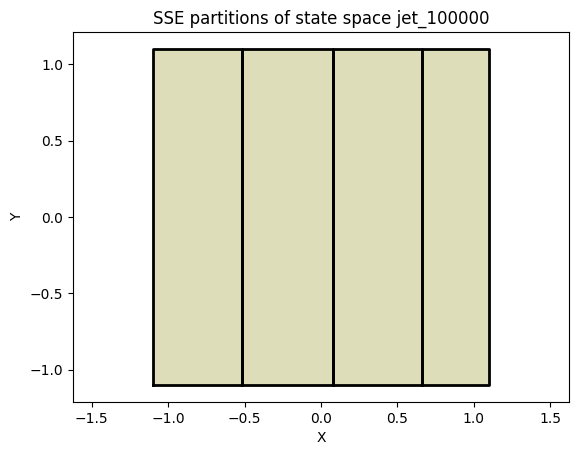

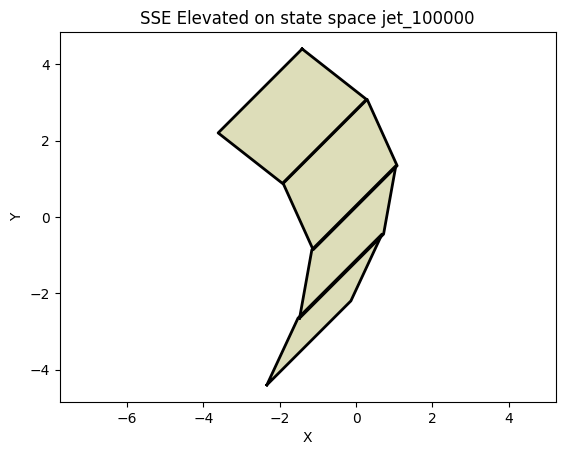

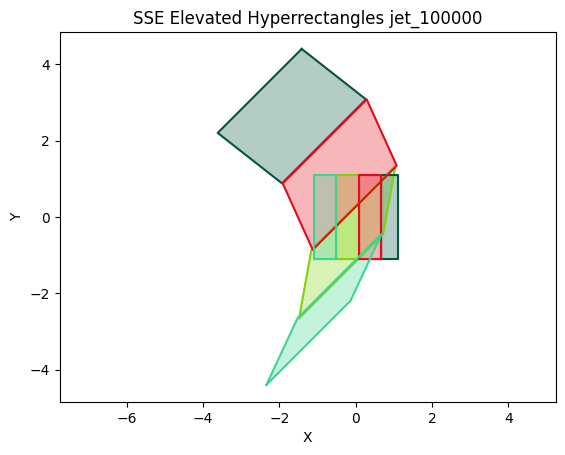

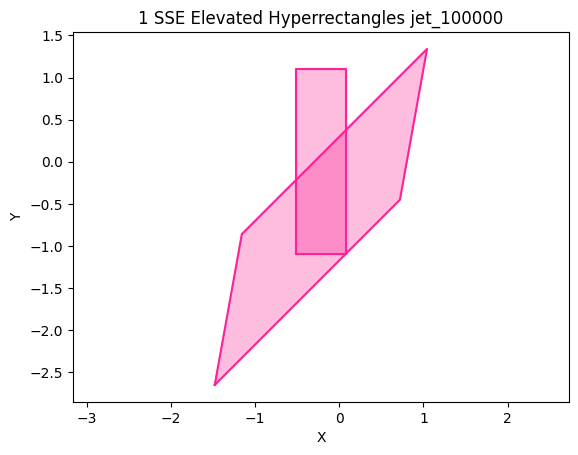

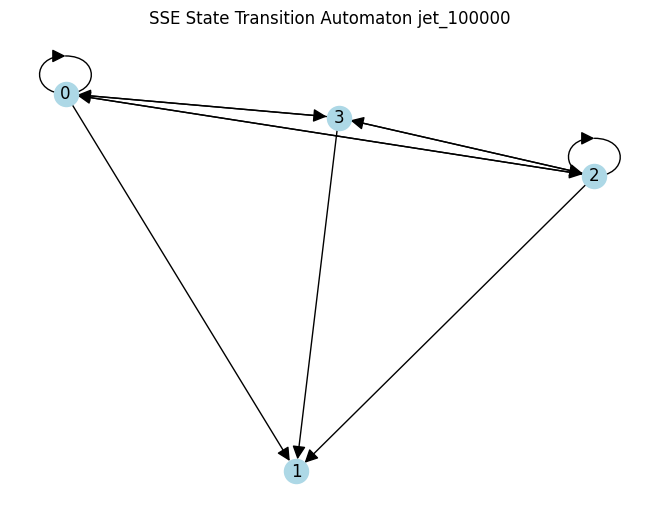

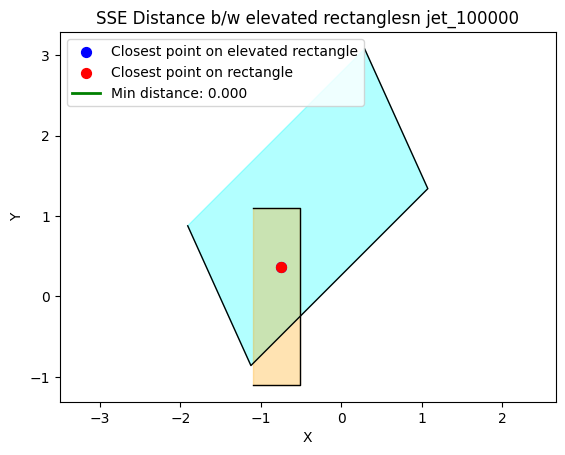

Saved results for jet, 100000


In [110]:
# Directory to store experiment results
os.makedirs("experiment_results", exist_ok=True)
results_file = "experiment_results/all_experiments.csv"

# Load previous results if they exist
if os.path.exists(results_file):
    df_all = pd.read_csv(results_file)
    completed = set(zip(df_all["system"], df_all["n_samples"]))
    results = df_all.to_dict("records")  # keep results list in memory too
    print(f"Resuming... {len(completed)} experiments already done")
else:
    completed = set()
    results = []

# Create a logs directory if it doesn't exist
os.makedirs("experiment_results/logs", exist_ok=True)

# Configure logging
logging.basicConfig(
    filename="experiment_results/logs/exceptions.log",
    level=logging.ERROR,
    format="%(asctime)s - %(levelname)s - %(message)s"
)



    

name_of_systems = ["jet",
        "exp",
        "steam",
        "jet",
        "nl1",
        "nl2",
        "lin",
        "vdp",
        "sine2d"]

# "tank", "nonlin-osc"
list_of_n_samples = [ 100000, 30000, 60000, 100000, 1000000]
for sys_name in name_of_systems[:1]:
    for n_samples in list_of_n_samples[:1]:

        # Skip if already completed
        if (sys_name, n_samples) in completed:
            print(f"Skipping {sys_name}, {n_samples} (already done)")
            continue

        
        print(f"Running {sys_name}, {n_samples}")
        try:
            if sys_name == "navigation_old":
                X, y = load_dataset(f"Dataset/{sys_name}/{sys_name}_{n_samples}/data_{sys_name}_{n_samples}.csv",num_attributes=4, num_classes=4)
            else:
                X, y = generate_save_benchmark_dataset(benchmark_name = sys_name, n_samples=n_samples)
            print("Name of the System = ", sys_name)
            X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.1)
            print(f" Shape of X_Training = {X_train.shape} \n Shape of X_Testing = {X_test.shape}")
            print(f" Shape of Y_Training = {y_train.shape} \n Shape of Y_Testing = {y_test.shape}")
            tree = DecisionTreeRegressor(max_depth=2)
            tree.fit(X_train, y_train)
            nrmse_tree_training = normalized_root_mean_square_error(y_train, tree.predict(X_train))
            print("NRMSE [Tree Based] of Training = ", nrmse_tree_training)
            nrmse_tree_testing = normalized_root_mean_square_error(y_test, tree.predict(X_test))
            print("NRMSE [Tree Based] of Testing  = ", nrmse_tree_testing)
            
            COF_model_tree_SSE = train_COF_on_leaves_parallel(X_train, y_train, tree, optimizer="cvxy", n_jobs=16)
            
            
            # try:
            nrmse_COF_model_tree_SSE_training = normalized_root_mean_square_error(y_train, predict_from_COF(COF_model_tree_SSE, X_train, tree))
            # except Exception as e:
            #     # Catch all exceptions
            #     print("Exception here")
            #     print(f"sys_name={sys_name}, n_samples={n_samples}")
            #     print(COF_model_tree_SSE)
            #     print(f"An error occurred: {e}")
            #     raise ValueError("just to stop execution")
            
            nrmse_COF_model_tree_SSE_testing = normalized_root_mean_square_error(y_test, predict_from_COF(COF_model_tree_SSE, X_test, tree))
            print("NRMSE [SSE COF Based] of Training = ", nrmse_COF_model_tree_SSE_training)
            print("NRMSE [SSE COF Based] of Testing  = ", nrmse_COF_model_tree_SSE_testing)
    
            
            # Following are the all h values which is an array
            SSE_high_h = get_h_from_COF(COF_model_tree_SSE, greater_then= -np.inf)
            # print("SSE_high_h", SSE_high_h)
    
            SSE_constraints_on_leaves = get_feature_bounds_from_COF(COF_model_tree_SSE)
   
            SSE_vertices_of_hyperrectangle = customHyperrectangle.getVerticesFromBounds(SSE_constraints_on_leaves)
            
            plotHyperrectanglesOfStateSpace(SSE_vertices_of_hyperrectangle,savePath=f"Dataset/{sys_name}/{sys_name}_{n_samples}/SSE partitions of state space.png", title=f"SSE partitions of state space {sys_name}_{n_samples}")
            #plot_hyperrectangles(SSE_vertices_of_hyperrectangle, X_train, y_train , line_style='scatter')
            
            SSE_elevated_vertices = get_elevated_vertices(COF_model_tree_SSE, SSE_vertices_of_hyperrectangle)
            
            # Plot only Elevated Hyperrectangles
            plotHyperrectanglesOfStateSpace(SSE_elevated_vertices,savePath=f"Dataset/{sys_name}/{sys_name}_{n_samples}/SSE Elevated on state space.png", title=f"SSE Elevated on state space {sys_name}_{n_samples}")
            
            # Plot Dual Hyperrectangles
            plotElivatedHyperrectangles(SSE_vertices_of_hyperrectangle, SSE_elevated_vertices,savePath=f"Dataset/{sys_name}/{sys_name}_{n_samples}/SSE Elevated Hyperrectangles.png", title=f"SSE Elevated Hyperrectangles {sys_name}_{n_samples}")
            
            # Plot only one Dual Hyperrectangle
            
            plotElivatedHyperrectangles(SSE_vertices_of_hyperrectangle[:1], SSE_elevated_vertices[:1],savePath=f"Dataset/{sys_name}/{sys_name}_{n_samples}/1 SSE Elevated Hyperrectangles.png", title=f"1 SSE Elevated Hyperrectangles {sys_name}_{n_samples}")
            
            SSE_state_transition_matrix = getStateTransitionMatrix(SSE_vertices_of_hyperrectangle, SSE_elevated_vertices, COF_model_tree_SSE)
            
            plotStateSpaceTransition(SSE_state_transition_matrix, savePath=f"Dataset/{sys_name}/{sys_name}_{n_samples}/SSE State Transition Automaton.png", title=f"SSE State Transition Automaton {sys_name}_{n_samples}")
            
            if SSE_elevated_vertices[0].shape[1] < 4:
                random_index = random.randrange(0,len(SSE_elevated_vertices)-1)
                plotDistanceBetweenTwoHyperrectangles(SSE_elevated_vertices[random_index], SSE_vertices_of_hyperrectangle[random_index+1], savePath=f"Dataset/{sys_name}/{sys_name}_{n_samples}/SSE Distance between elevated rectangles.png", title=f"SSE Distance b/w elevated rectanglesn {sys_name}_{n_samples}")
                
            #This section of code is just to save some results
            # Store in dict
            experiment_data = {
                "system": sys_name,
                "n_samples": n_samples,
                "X_train_shape": list(X_train.shape),
                "X_test_shape": list(X_test.shape),
                "y_train_shape": list(y_train.shape),
                "y_test_shape": list(y_test.shape),
                "NRMSE_Tree_Train":  float(nrmse_tree_training), 
                "NRMSE_Tree_Test": float(nrmse_tree_testing),
                "NRMSE_SSE_Train":  float(nrmse_COF_model_tree_SSE_training), 
                "NRMSE_SSE_Test": float(nrmse_COF_model_tree_SSE_testing),
                
                "h_values_SSE": SSE_high_h,
                
            }
        
            results.append(experiment_data)
            # Save after every experiment
            pd.DataFrame(results).to_csv(results_file, index=False)
            print(f"Saved results for {sys_name}, {n_samples}")
            #This section of code is just to save some results
        
        except Exception as e:
            print(f"Error in {sys_name}, {n_samples}: {e}")
            logging.error(f"Error in {sys_name}, {n_samples}", exc_info=True)
            continue
    


In [101]:
get_h_from_COF(COF_model_tree_SSE)

[0.007358356411759284,
 0.002960903329331717,
 0.00020246555375998037,
 0.004040940781840513,
 0.0002038663054062304,
 0.004010308359086448,
 0.007336299402580824,
 0.002961023682303256]

In [108]:
get_h_from_COF(COF_model_tree_SSE)

[np.float64(0.003936500594370046),
 np.float64(0.006614639427895403),
 np.float64(9.256531555489467e-05),
 np.float64(0.004422851096205125)]

In [114]:
COF_model_tree_SSE

[{'leaf_id': np.int64(3),
  'CO_Model': {'M': array([[ 0.53893889, -1.00000783],
          [ 3.00000002, -1.        ]]),
   'm0': array([-1.00442974e-01,  1.82025197e-09]),
   'h': np.float64(0.0027248055002214665)},
  'no_samples': 24399,
  'indices': [0,
   1,
   6,
   8,
   13,
   14,
   16,
   17,
   19,
   26,
   28,
   29,
   32,
   37,
   41,
   44,
   47,
   49,
   52,
   53,
   54,
   57,
   60,
   61,
   64,
   73,
   76,
   78,
   82,
   83,
   102,
   108,
   111,
   117,
   121,
   123,
   124,
   127,
   130,
   131,
   134,
   138,
   140,
   142,
   143,
   144,
   145,
   147,
   151,
   156,
   161,
   162,
   164,
   168,
   179,
   180,
   187,
   202,
   207,
   209,
   213,
   226,
   227,
   228,
   232,
   234,
   242,
   244,
   245,
   252,
   255,
   266,
   267,
   271,
   273,
   280,
   288,
   294,
   296,
   300,
   302,
   303,
   307,
   314,
   315,
   319,
   326,
   328,
   331,
   342,
   344,
   350,
   352,
   353,
   355,
   357,
   364,
   366,

In [23]:
for item in SSE_state_transition_matrix:
    print(item)
    

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0.]
[1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 

In [113]:
from SpaceEx.cof_to_spaceex import build_spaceex_xml_from_cof
from SpaceEx.Regression_abstraction_to_spaceex_export import parse_cof_list, build_spaceex_xml

In [ ]:
xml_txt, cfg_txt = export_spaceex(
    cof_model=COF_model,
    trans_matrix=T,
    system_name="NeuralAbstraction",
    initial_box=init_box,
    forbidden_box=forb_box,     # or None
    cfg_options=dict(time_horizon=10.0, sampling_time=0.02)
)

with open("NeuralAbstraction.xml","w") as f: f.write(xml_txt)
with open("NeuralAbstraction.cfg","w") as f: f.write(cfg_txt)


In [54]:
"""
out_xml = "pwa_from_cof_spaceex.xml"
# build xml

build_spaceex_xml_from_cof(COF_model_tree_SSE, SSE_state_transition_matrix, outpath=out_xml,
                          use_h_expansion=False, expand_factor=1.0,
                          tau_max=1.0, clock_name='t',
                          initial_region_idx=0)
"""
"""
custom_box = [[-0.4, -0.2], [-1.0, -0.8]]  # [ [min,max] for x0 , [min,max] for x1 ]
build_spaceex_xml_from_cof(COF_model_tree_SSE, SSE_state_transition_matrix, outpath=out_xml,
                          use_h_expansion=False, expand_factor=1.0,
                          tau_max=1.0, clock_name='t', initial_region_idx=1,   # optional, just to label the region
                           initial_box=custom_box)
"""
"""
initial_box = [[0.45, 0.50], [-0.60, -0.55]]  # X0
unsafe_box = [[0.3, 0.35], [0.5, 0.6]]       # XB
tau_max = 1.5

build_spaceex_xml_from_cof(
    cof_list=COF_model_tree_SSE,
    transitions=SSE_state_transition_matrix,
    outpath="jet_spaceex_with_property.xml",
    state_var_names=["x","y"],
    tau_max=tau_max,
    initial_box=initial_box,
    unsafe_box=unsafe_box,
    allow_self_loops=False
)
"""

Wrote SpaceEx XML to jet_spaceex_with_property.xml (L=32, dim=2)
Wrote SpaceEx CFG to jet_spaceex_with_property.cfg


('jet_spaceex_with_property.xml', 'jet_spaceex_with_property.cfg')

In [109]:
"""
initial_box = [[0.45, 0.50], [-0.60, -0.55]]  # X0
unsafe_box = [[0.3, 0.35], [0.5, 0.6]]       # XB
tau_max = 1.5
"""

initial_box = [[-0.1, 0.1], [-0.1, 0.1]]  # X0
unsafe_box = [[0.8, 1.1], [0.8, 1.1]]       # XB
tau_max = 1.5


build_spaceex_xml_from_cof(
        cof_list=COF_model_tree_SSE,
        transitions=SSE_state_transition_matrix,
        outpath="jet_spaceex_full.xml",
        state_var_names=["x", "y"],
        tau_max=tau_max,
        initial_box=initial_box,
        unsafe_box=unsafe_box,
        system_name="JetSystem"
    )

"""
xml_file, cfg_file = build_spaceex_xml_from_cof(
    cof_list=COF_model_tree_SSE,
    transitions=SSE_state_transition_matrix,
    outpath="jet_spaceex_full.xml",
    system_name="JetSystem",
    state_var_names=["x","y"],
    tau_max=tau_max,
    initial_box=initial_box,
    unsafe_box=unsafe_box,
    use_h_expansion=True,
    expand_factor=1.0,
    use_h_flow=True
)
"""

Wrote SpaceEx XML to jet_spaceex_full.xml (L=4, dim=2)
Wrote SpaceEx CFG to jet_spaceex_full.cfg


'\nxml_file, cfg_file = build_spaceex_xml_from_cof(\n    cof_list=COF_model_tree_SSE,\n    transitions=SSE_state_transition_matrix,\n    outpath="jet_spaceex_full.xml",\n    system_name="JetSystem",\n    state_var_names=["x","y"],\n    tau_max=tau_max,\n    initial_box=initial_box,\n    unsafe_box=unsafe_box,\n    use_h_expansion=True,\n    expand_factor=1.0,\n    use_h_flow=True\n)\n'

In [ ]:
"""
This produces a SpaceEx XML exactly compatible with Neural Abstractions style:
-Locations = leaf regions
-Invariants = optionally expanded by h
-Flows = M x + m0 + d_i with d_i ∈ [-h_i, h_i]
-Initial = Jet X0
-Unsafe property = XB
-Transitions = our matrix

"""

initial_box = [[0.45, 0.50], [-0.60, -0.55]]  # X0
unsafe_box = [[0.3, 0.35], [0.5, 0.6]]       # XB
tau_max = 1.5

xml_file, cfg_file = build_spaceex_xml_from_cof(
    cof_list=COF_model_tree_SSE,
    transitions=SSE_state_transition_matrix,
    outpath="jet_spaceex_full.xml",
    system_name="JetSystem",
    state_var_names=["x","y"],
    tau_max=tau_max,
    initial_box=initial_box,
    unsafe_box=unsafe_box,
    use_h_expansion=True,
    expand_factor=1.0,
    use_h_flow=True
)


In [79]:
getStateTransitionMatrix(SSE_vertices_of_hyperrectangle, SSE_elevated_vertices, COF_model_tree_SSE)
getStateTransitionMatrix(MSE_vertices_of_hyperrectangle, MSE_elevated_vertices, COF_model_tree_MSE)

[[np.float64(0.1623833892529826), 1.8269569024137988], [np.float64(0.22299886589631934), 1.8269569024137988], [np.float64(1.6083697190817463), 1.8269569024137988], [np.float64(0.504069718897452), 1.8269569024137988], [np.float64(0.38590641121387825), 1.8269569024137988], [np.float64(0.4203613800266092), 1.8269569024137988], [np.float64(0.26751440422038186), 1.8269569024137988], [np.float64(0.26075107367209277), 1.8269569024137988], [np.float64(1.5927958199729648), 1.8269569024137988], [np.float64(4.902034866782353e-05), 1.8269569024137988], [np.float64(1.5521516254027716), 1.8269569024137988], [np.float64(0.16728601531937995), 1.8269569024137988], [np.float64(1.7335774820569558), 1.8269569024137988], [np.float64(1.2336751306835349e-05), 1.8269569024137988], [np.float64(1.483483770295315), 1.8269569024137988], [np.float64(1.4002681263459498), 1.8269569024137988], [np.float64(1.476996882617563), 1.8269569024137988], [np.float64(1.4065645134821632), 1.8269569024137988], [np.float64(1.6369

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
# print(SSE_state_transition_matrix)
num_transitions = sum(np.sum(row != 0.0) for row in MSE_state_transition_matrix)
print(f"Number of transitions = {num_transitions}")
counter = 0
for row in MSE_state_transition_matrix:
    print(str(np.sum(row == 1)) + " <->" + ' '.join(map(str, row)))

Number of transitions = 62
5 <->0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
8 <->1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0
3 <->0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0 <->0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
6 <->1.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
6 <->0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0 <->0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0 <->0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

In [69]:
plotMinDistance(SSE_vertices_of_hyperrectangle[:0], SSE_elevated_vertices[:0], COF_model_tree_SSE[:0]['CO_Model']['h'])

NameError: name 'plotMinDistance' is not defined

In [87]:
count = np.sum(SSE_high_h < MSE_high_h)
print("Number of rows where SSE < MSE:", count)

Number of rows where SSE < MSE: 0


In [ ]:
plotMinDistance

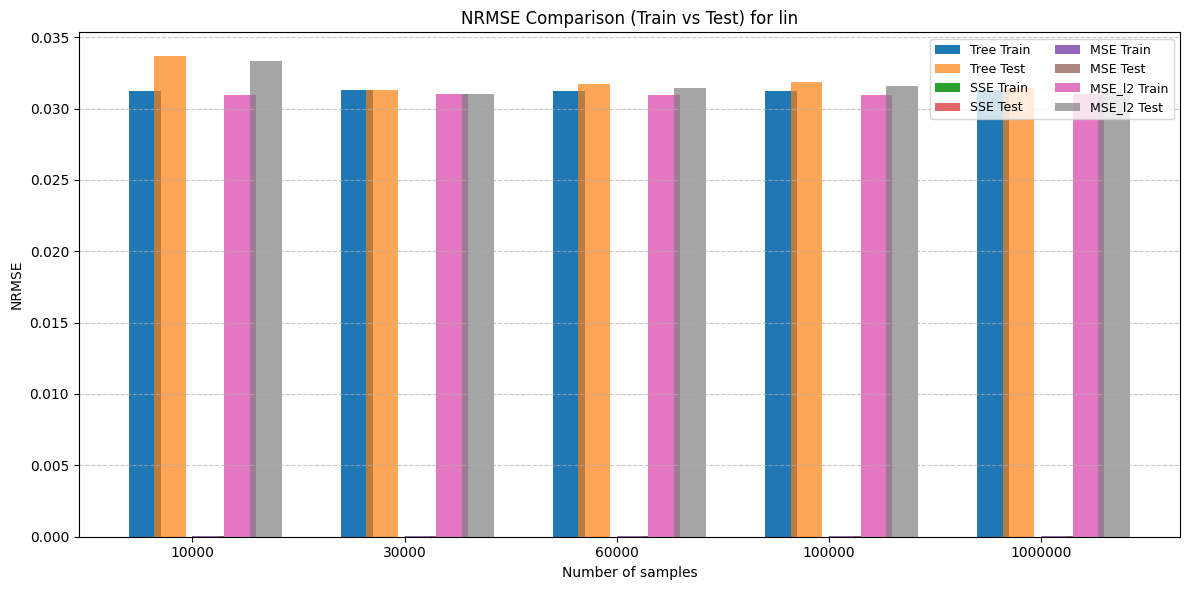

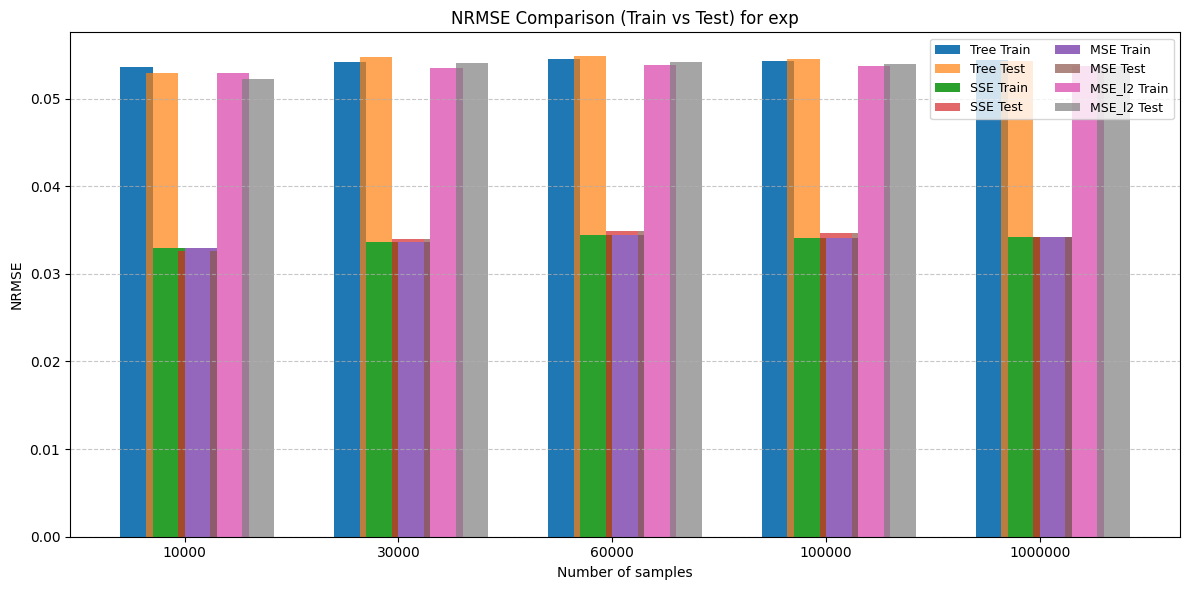

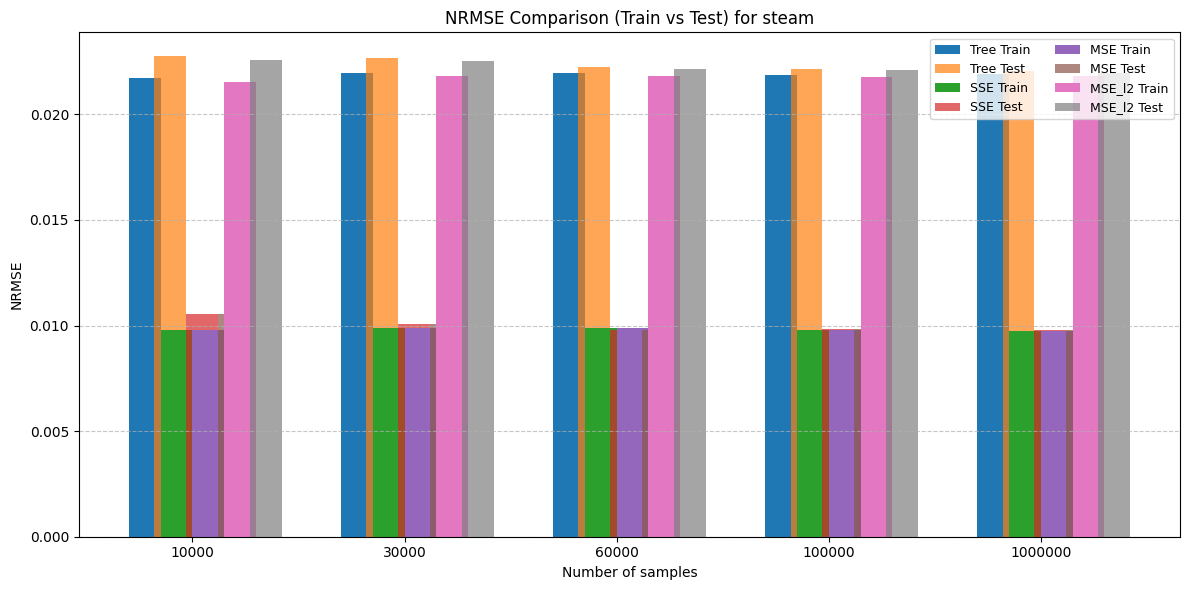

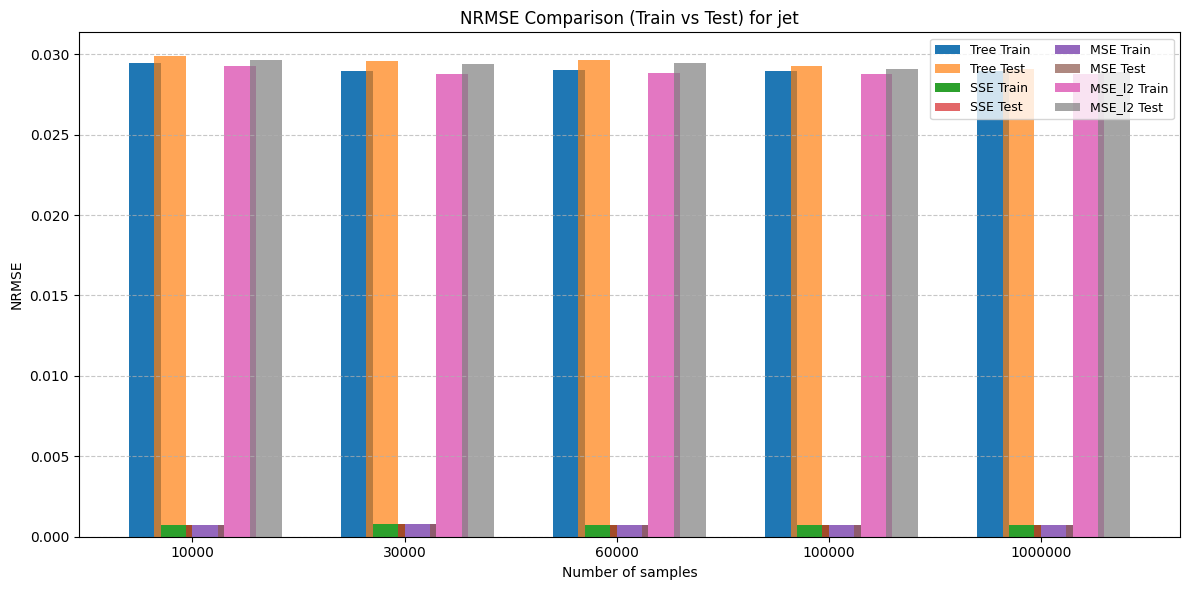

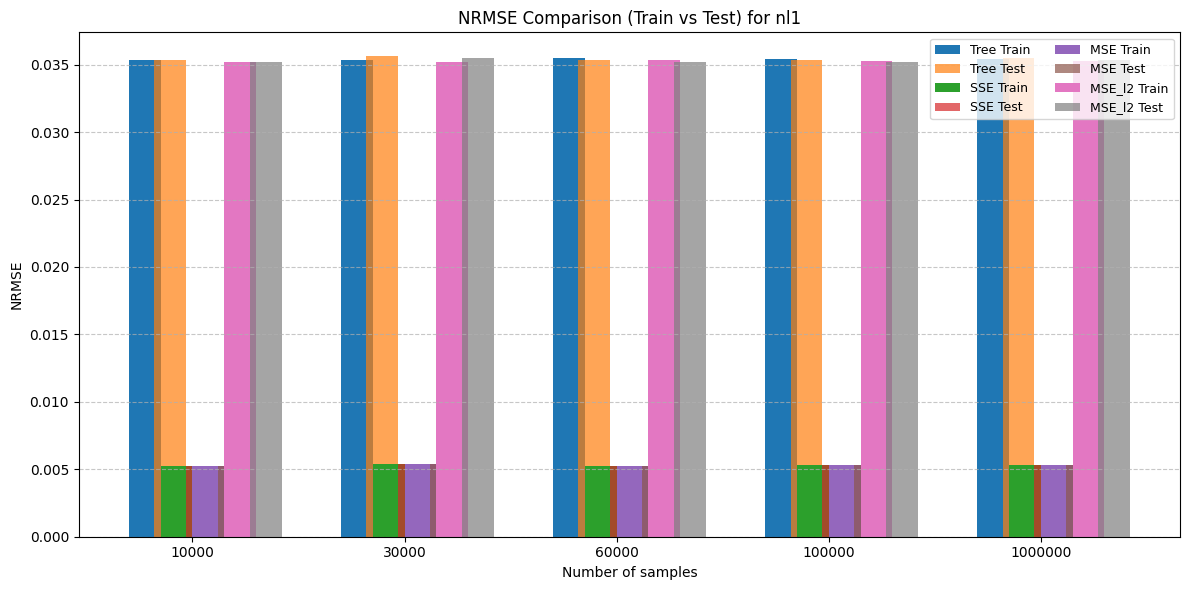

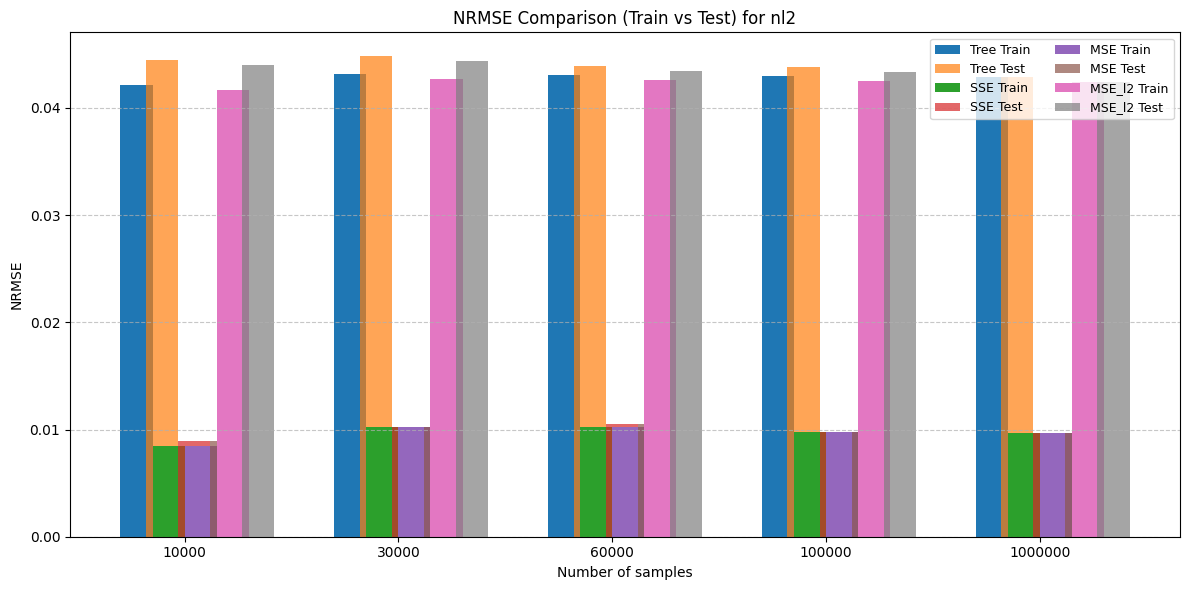

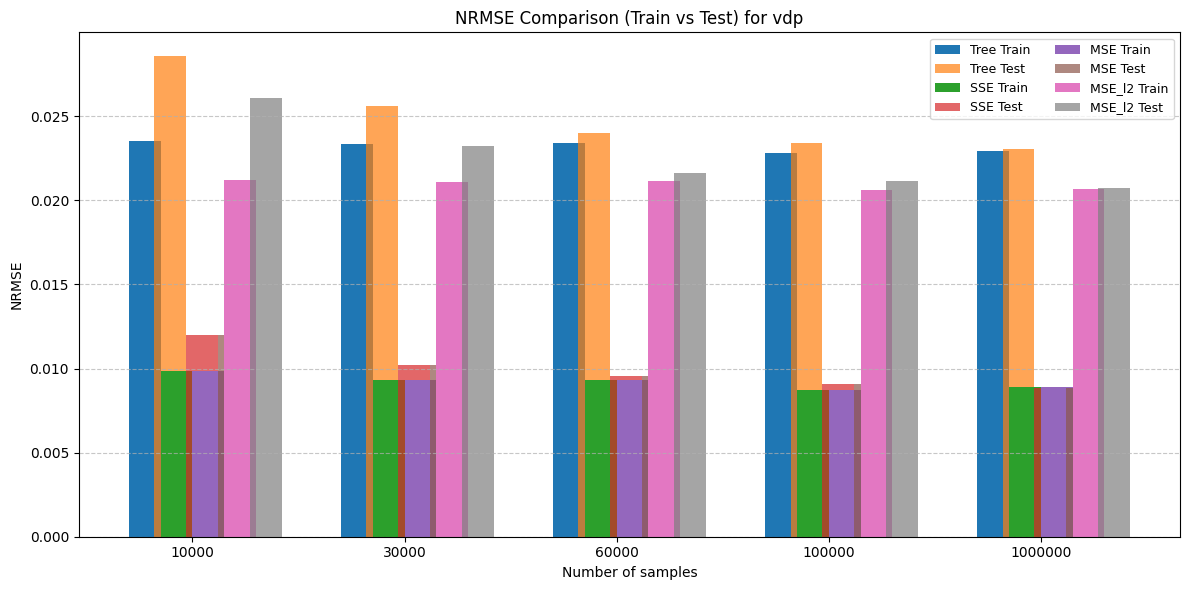

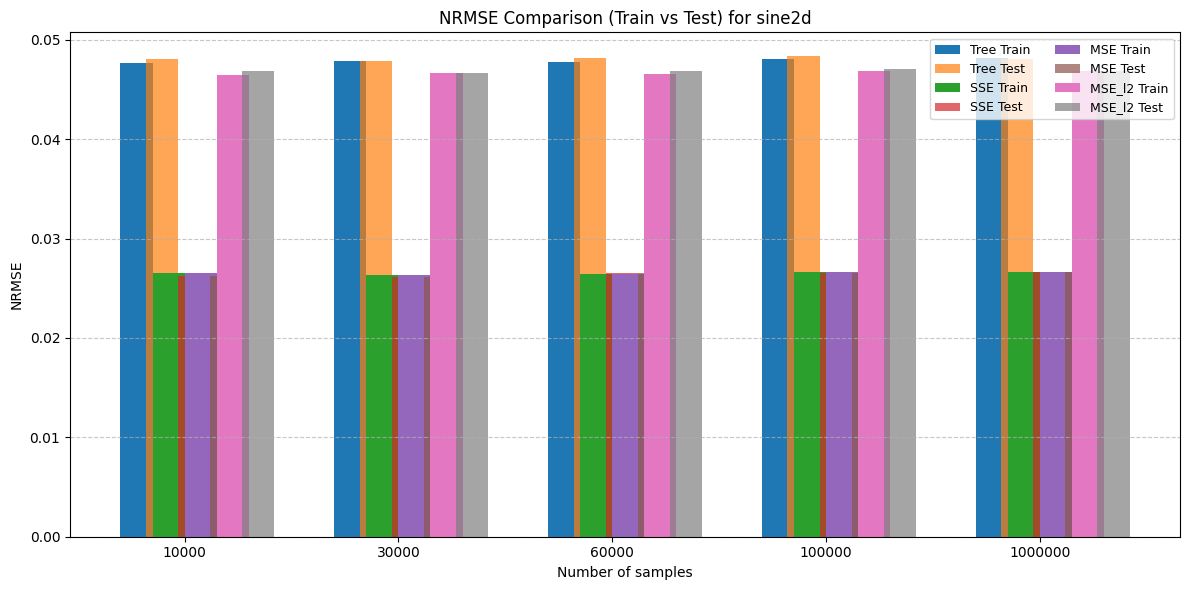

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the results
df_all = pd.read_csv("experiment_results/all_experiments.csv")

name_of_systems = ["lin", "exp", "steam", "jet", "nl1", "nl2", "vdp", "sine2d"]


for sys_name in name_of_systems:
    # System to plot
    # sys_name = "steam"
    df_sys = df_all[df_all["system"] == sys_name]
    
    # Sample sizes
    samples = sorted(df_sys["n_samples"].unique())
    
    # Metrics
    metrics = ["Tree", "SSE", "MSE", "MSE_l2"]
    
    # Widths
    bar_width = 0.15
    x = np.arange(len(samples))  # positions for sample sizes
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, metric in enumerate(metrics):
        # Training bars
        train_values = [df_sys[df_sys["n_samples"] == n][f"NRMSE_{metric}_Train"].values[0] for n in samples]
        ax.bar(x + i*bar_width, train_values, width=bar_width, label=f"{metric} Train")
        
        # Testing bars (offset slightly)
        test_values = [df_sys[df_sys["n_samples"] == n][f"NRMSE_{metric}_Test"].values[0] for n in samples]
        ax.bar(x + i*bar_width + bar_width*0.8, test_values, width=bar_width, label=f"{metric} Test", alpha=0.7)
    
    ax.set_xticks(x + bar_width*1.5)  # center tick labels
    ax.set_xticklabels(samples)
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("NRMSE")
    ax.set_title(f"NRMSE Comparison (Train vs Test) for {sys_name}")
    ax.legend(fontsize=9, ncol=2)
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"Dataset/{sys_name}/NRMSE_Train_Test_comparison.png")
    plt.show()


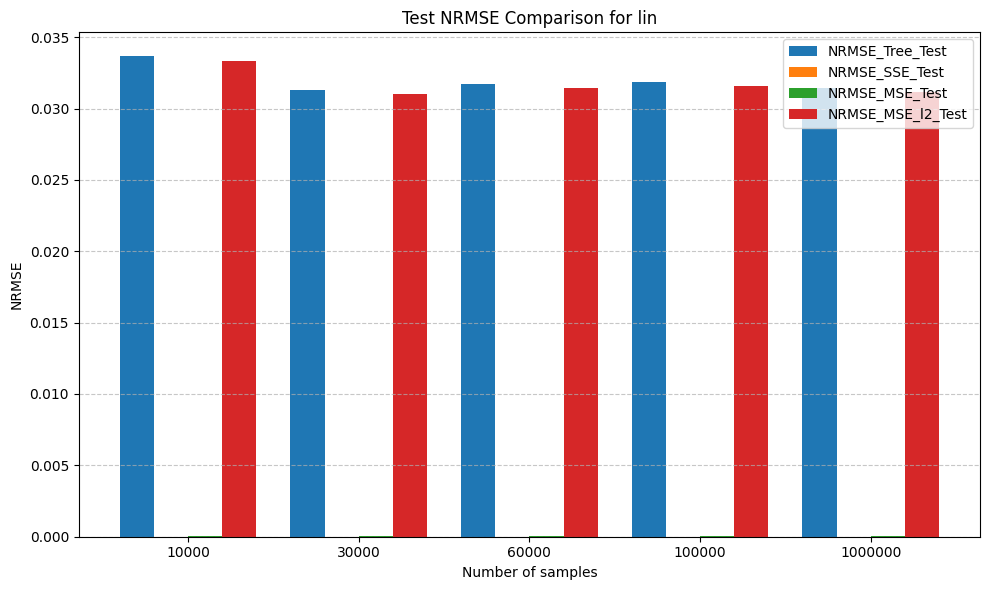

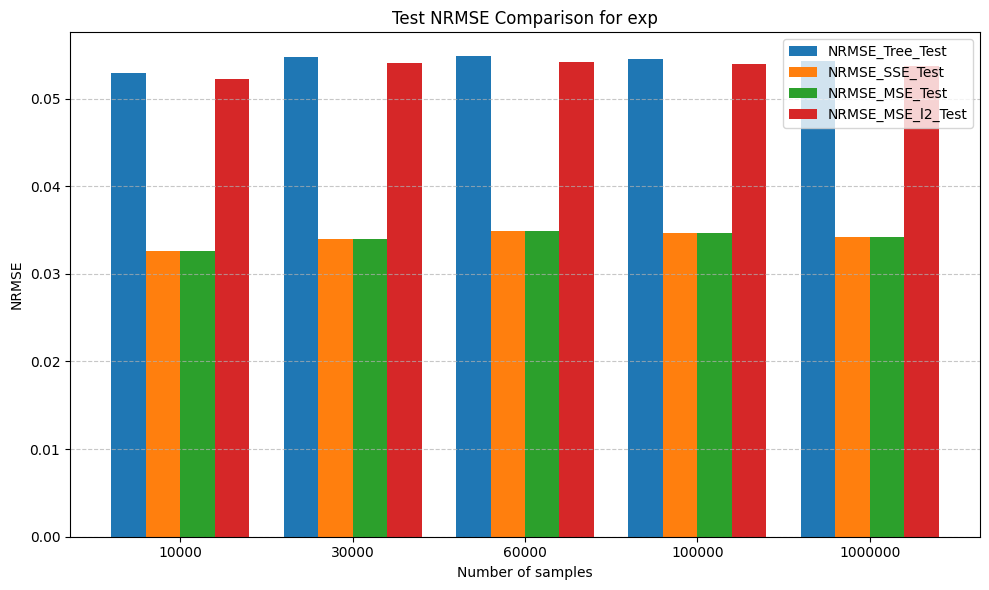

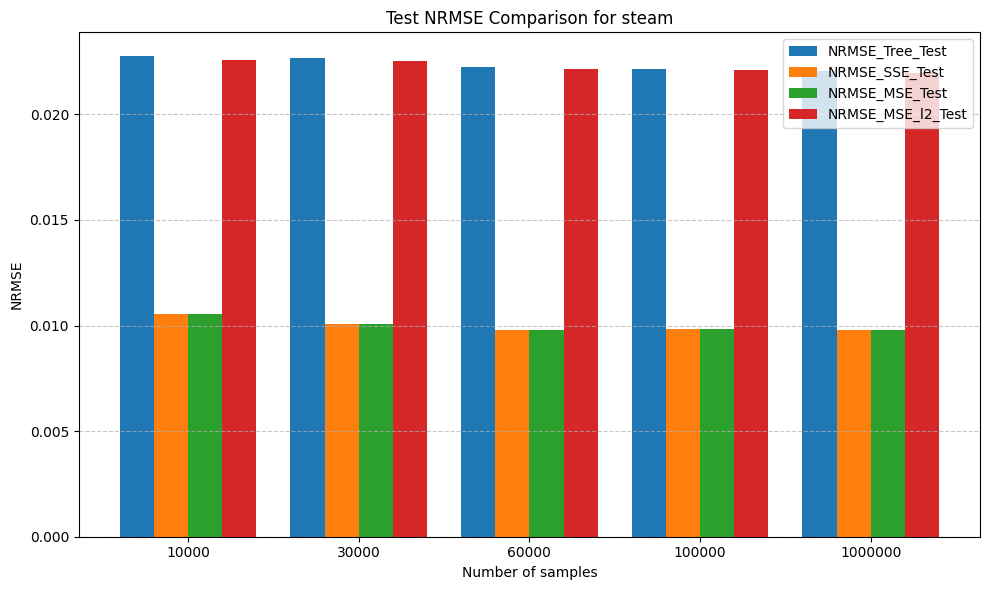

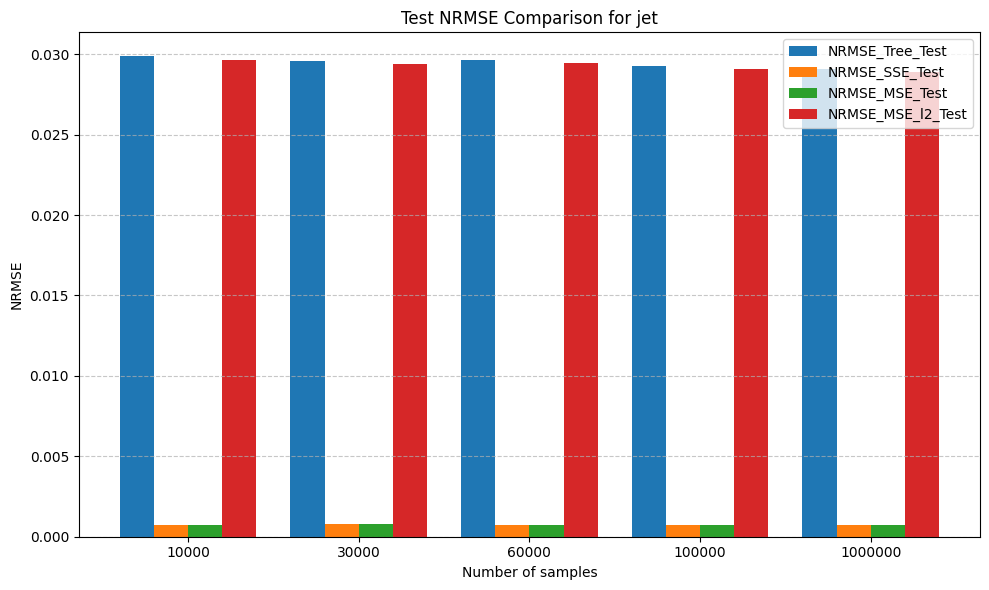

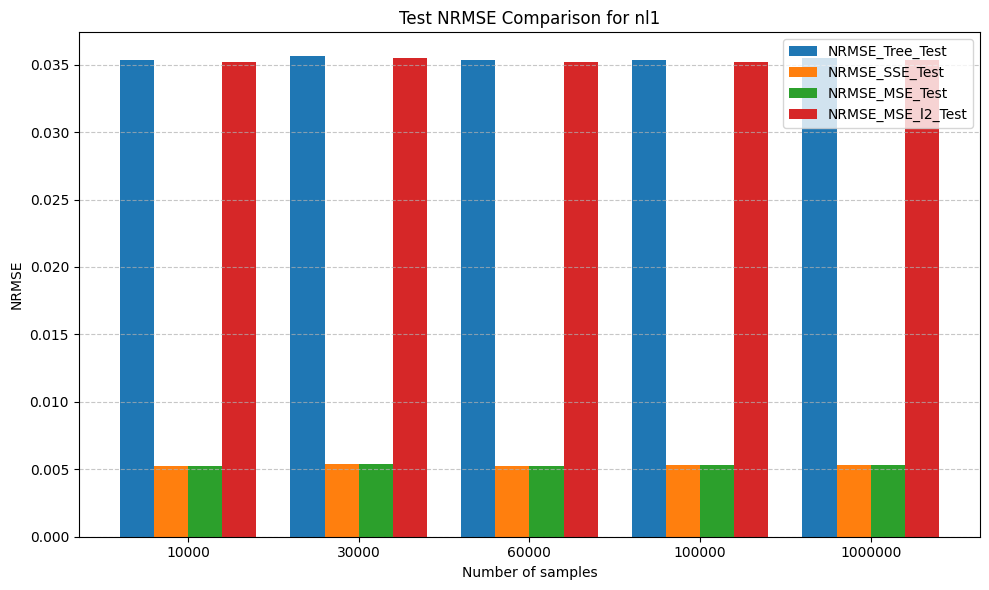

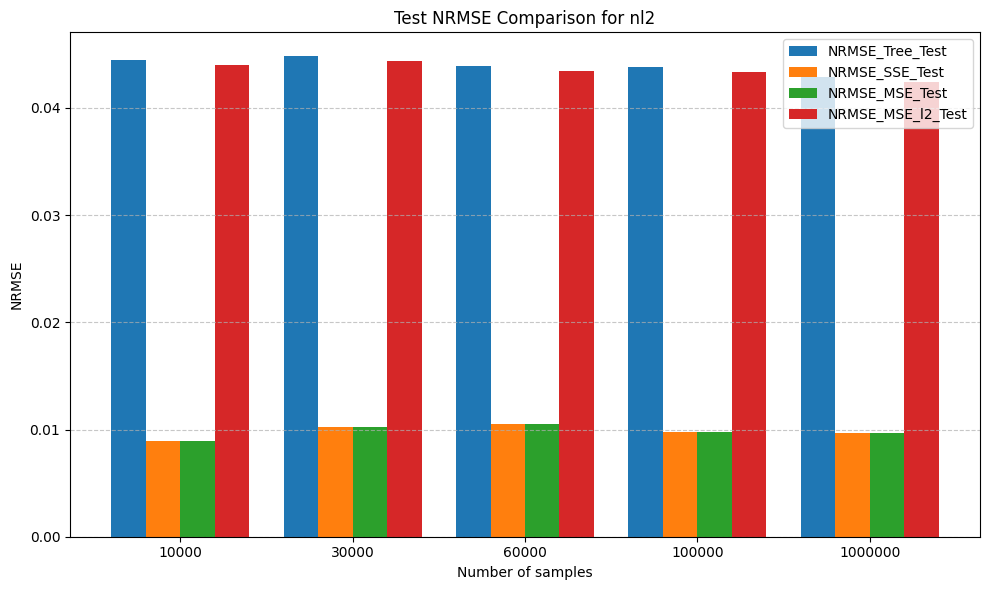

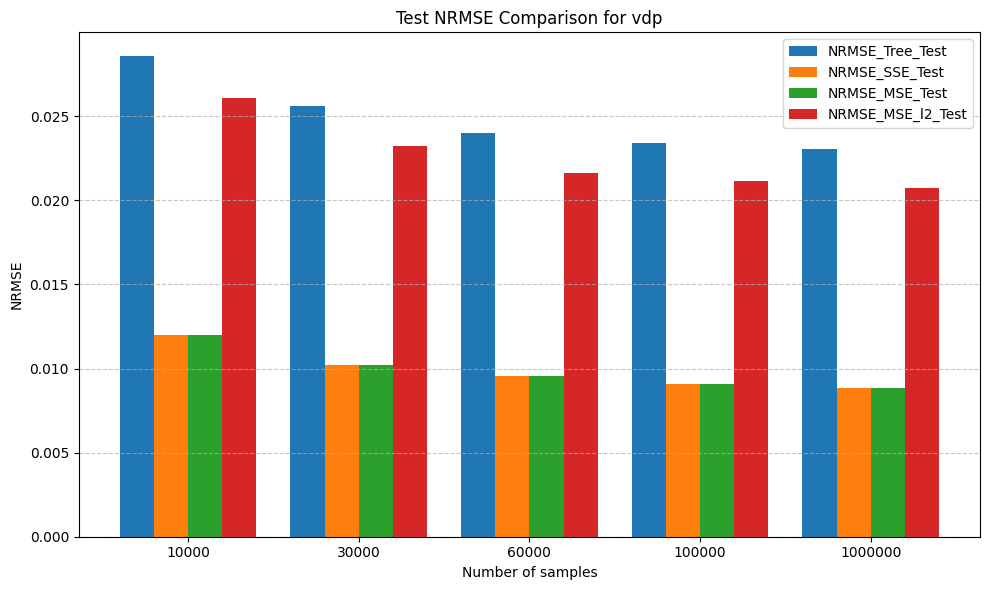

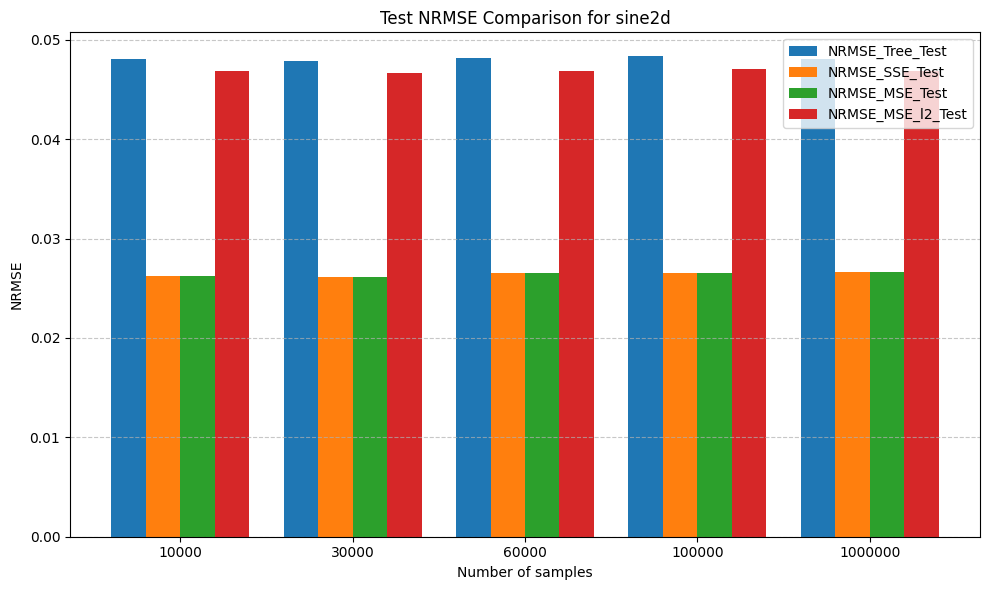

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the results
df_all = pd.read_csv("experiment_results/all_experiments.csv")

name_of_systems = ["lin", "exp", "steam", "jet", "nl1", "nl2", "vdp", "sine2d"]
metrics = ["NRMSE_Tree_Test", "NRMSE_SSE_Test", "NRMSE_MSE_Test", "NRMSE_MSE_l2_Test"]

for sys_name in name_of_systems:
    df_sys = df_all[df_all["system"] == sys_name]
    
    # Get all sample sizes
    samples = sorted(df_sys["n_samples"].unique())
    
    # Width of each bar
    bar_width = 0.2
    x = np.arange(len(samples))  # positions for sample sizes
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, metric in enumerate(metrics):
        # Offset bars so they don't overlap
        offsets = x + (i - 1.5) * bar_width  # center around 0
        values = [df_sys[df_sys["n_samples"] == n][metric].values[0] for n in samples]
        ax.bar(offsets, values, width=bar_width, label=metric)
    
    ax.set_xticks(x)
    ax.set_xticklabels(samples)
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("NRMSE")
    ax.set_title(f"Test NRMSE Comparison for {sys_name}")
    ax.legend()
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(f"Dataset/{sys_name}/NRMSE_Test_comparison_barplot.png")
    plt.show()


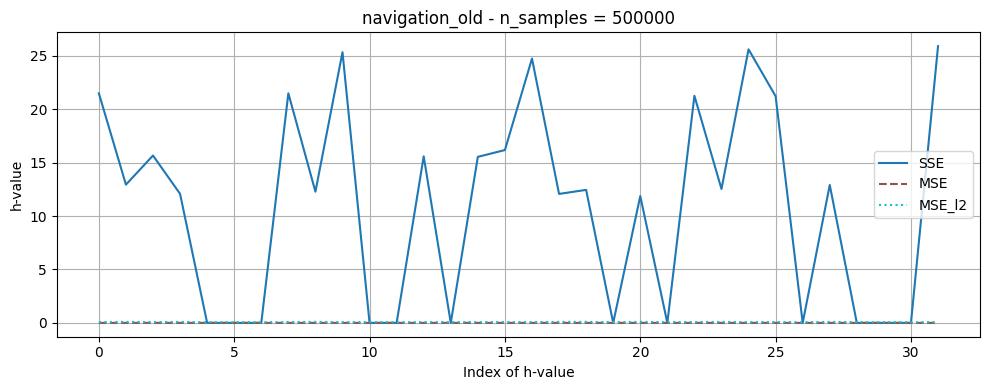

In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast

# Load the results
df_all = pd.read_csv("experiment_results/all_experiments.csv")

# Convert stringified arrays back into numpy arrays (if needed)
for col in ["h_values_SSE", "h_values_MSE", "h_values_MSE_l2"]:
    df_all[col] = df_all[col].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )

name_of_systems = ["navigation_old"]
# ["lin",
#         "exp",
#         "steam",
#         "jet",
#         "nl1",
#         "nl2",
        
#         "vdp",
#         "sine2d"]

# "tank", "nonlin-osc"

for sys_name in name_of_systems:
    # Choose a system
    #sys_name = "steam"   # <-- change this to whichever system you want
    df_sys = df_all[df_all["system"] == sys_name]
    
    # Get all sample sizes
    samples = sorted(df_sys["n_samples"].unique())
    color_map = plt.colormaps.get_cmap("tab10").resampled(3)  # SSE/MSE/MSE_l2 colors
    
    # Create subplots: 1 row per sample size
    fig, axes = plt.subplots(len(samples), 1, figsize=(10, 4*len(samples)), sharex=True)
    
    if len(samples) == 1:
        axes = [axes]  # make it iterable if only one subplot
    
    for idx, n in enumerate(samples):
        subset = df_sys[df_sys["n_samples"] == n].iloc[0]
    
        x_SSE = np.arange(len(subset["h_values_SSE"]))
        x_MSE = np.arange(len(subset["h_values_MSE"]))
        x_MSE_l2 = np.arange(len(subset["h_values_MSE_l2"]))
    
        ax = axes[idx]
        ax.plot(x_SSE, subset["h_values_SSE"], label="SSE", color=color_map(0), linestyle="-")
        ax.plot(x_MSE, subset["h_values_MSE"], label="MSE", color=color_map(1), linestyle="--")
        ax.plot(x_MSE_l2, subset["h_values_MSE_l2"], label="MSE_l2", color=color_map(2), linestyle=":")
    
        ax.set_title(f"{sys_name} - n_samples = {n}")
        ax.set_ylabel("h-value")
        ax.grid(True)
        ax.legend()
    
    axes[-1].set_xlabel("Index of h-value")  # only x-label for bottom subplot
    plt.tight_layout()
    plt.savefig(f"Dataset/{sys_name}/h_values_comparison_graph.png")
    plt.show()


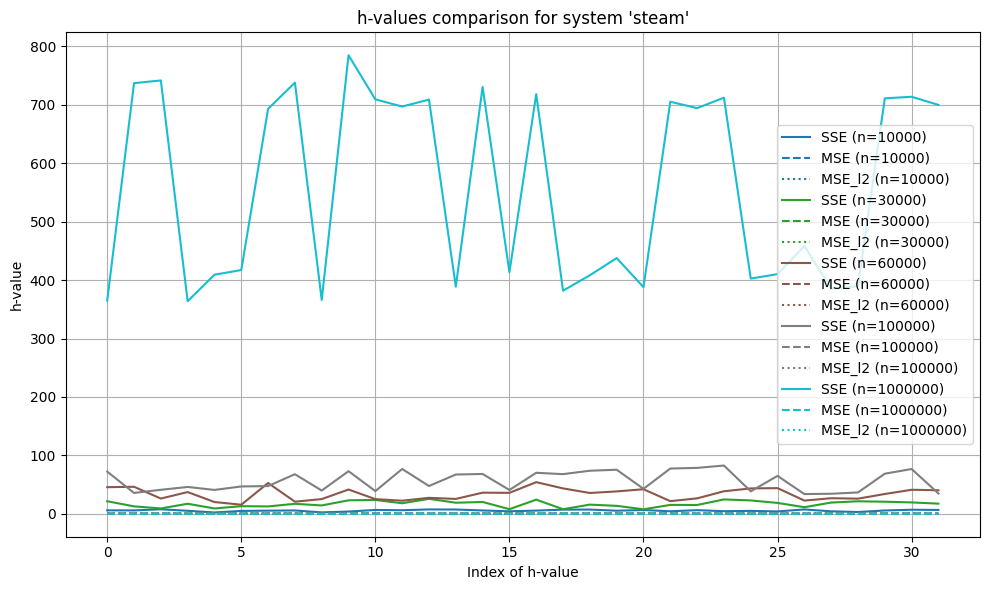

In [16]:
'''
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast

# Load the results
df_all = pd.read_csv("experiment_results/all_experiments.csv")

# Convert stringified arrays back into numpy arrays
for col in ["h_values_SSE", "h_values_MSE", "h_values_MSE_l2"]:
    df_all[col] = df_all[col].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )

# Get all systems
systems = df_all["system"].unique()
samples = sorted(df_all["n_samples"].unique())

# Set up color map for systems
color_map = plt.colormaps.get_cmap("tab10").resampled(len(systems))

plt.figure(figsize=(12, 8))

for sys_idx, sys_name in enumerate(systems):
    df_sys = df_all[df_all["system"] == sys_name]
    
    for sample_idx, n in enumerate(samples):
        subset = df_sys[df_sys["n_samples"] == n]
        if len(subset) == 0:
            continue
        subset = subset.iloc[0]  # just take the first row for this n_samples

        x_SSE = np.arange(len(subset["h_values_SSE"]))
        x_MSE = np.arange(len(subset["h_values_MSE"]))
        x_MSE_l2 = np.arange(len(subset["h_values_MSE_l2"]))

        # Same color for the same system, different line style for SSE/MSE/MSE_l2
        plt.plot(x_SSE, subset["h_values_SSE"], 
                 label=f"{sys_name} SSE (n={n})", color=color_map(sys_idx), linestyle="-")
        plt.plot(x_MSE, subset["h_values_MSE"], 
                 label=f"{sys_name} MSE (n={n})", color=color_map(sys_idx), linestyle="--")
        plt.plot(x_MSE_l2, subset["h_values_MSE_l2"], 
                 label=f"{sys_name} MSE_l2 (n={n})", color=color_map(sys_idx), linestyle=":")

plt.title("h-values comparison across all systems")
plt.xlabel("Index of h-value")
plt.ylabel("h-value")
plt.legend(fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

'''


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast

# Load the results
df_all = pd.read_csv("experiment_results/all_experiments.csv")

# Convert stringified arrays back into numpy arrays (if needed)
for col in ["h_values_SSE", "h_values_MSE", "h_values_MSE_l2"]:
    df_all[col] = df_all[col].apply(
        lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
    )

# Choose a system
sys_name = "steam"   # <-- change this to whichever system you want
df_sys = df_all[df_all["system"] == sys_name]

# Define colors per n_samples (new API, no deprecation warning)
samples = sorted(df_sys["n_samples"].unique())
color_map = plt.colormaps.get_cmap("tab10").resampled(len(samples))

plt.figure(figsize=(10, 6))

for idx, n in enumerate(samples):
    # One row per sample size
    subset = df_sys[df_sys["n_samples"] == n].iloc[0]
    
    # X-axis for each h-value array
    x_SSE = np.arange(len(subset["h_values_SSE"]))
    x_MSE = np.arange(len(subset["h_values_MSE"]))
    x_MSE_l2 = np.arange(len(subset["h_values_MSE_l2"]))
    
    # Same color for same n_samples, different line styles
    plt.plot(x_SSE, subset["h_values_SSE"], 
             label=f"SSE (n={n})", color=color_map(idx), linestyle="-")
    plt.plot(x_MSE, subset["h_values_MSE"], 
             label=f"MSE (n={n})", color=color_map(idx), linestyle="--")
    plt.plot(x_MSE_l2, subset["h_values_MSE_l2"], 
             label=f"MSE_l2 (n={n})", color=color_map(idx), linestyle=":")

plt.title(f"h-values comparison for system '{sys_name}'")
plt.xlabel("Index of h-value")
plt.ylabel("h-value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
'''
        # Store in dict
        experiment_data = {
            "system": sys_name,
            "n_samples": n_samples,
            "X_train_shape": X_train.shape,
            "X_test_shape": X_test.shape,
            "y_train_shape": y_train.shape,
            "y_test_shape": y_test.shape,
            "NRMSE": {
                "Tree": {"train": float(nrmse_tree_training), "test": float(nrmse_tree_testing)},
                "SSE": {"train": float(nrmse_COF_model_tree_SSE_training), "test": float(nrmse_COF_model_tree_SSE_testing)},
                "MSE": {"train": float(nrmse_COF_model_tree_MSE_training), "test": float(nrmse_COF_model_tree_MSE_testing)},
                "MSE_l2": {"train": float(nrmse_COF_model_tree_MSE_l2_training), "test": float(nrmse_COF_model_tree_MSE_l2_testing)}
            },
            "h_values": {
                "SSE": SSE_high_h,
                "MSE": MSE_high_h,
                "MSE_l2": MSE_l2_high_h
            },
            "constraints": {
                "SSE": SSE_constraints_on_leaves,
                "MSE": MSE_constraints_on_leaves,
                "MSE_l2": MSE_l2_constraints_on_leaves
            }
        }

        results.append(experiment_data)


        

# Save all results to JSON
results_serializable = convert_to_serializable(results)

with open("experiment_results/all_experiments.json", "w") as f:
    json.dump(results_serializable, f, indent=4)

'''

'\n        # Store in dict\n        experiment_data = {\n            "system": sys_name,\n            "n_samples": n_samples,\n            "X_train_shape": X_train.shape,\n            "X_test_shape": X_test.shape,\n            "y_train_shape": y_train.shape,\n            "y_test_shape": y_test.shape,\n            "NRMSE": {\n                "Tree": {"train": float(nrmse_tree_training), "test": float(nrmse_tree_testing)},\n                "SSE": {"train": float(nrmse_COF_model_tree_SSE_training), "test": float(nrmse_COF_model_tree_SSE_testing)},\n                "MSE": {"train": float(nrmse_COF_model_tree_MSE_training), "test": float(nrmse_COF_model_tree_MSE_testing)},\n                "MSE_l2": {"train": float(nrmse_COF_model_tree_MSE_l2_training), "test": float(nrmse_COF_model_tree_MSE_l2_testing)}\n            },\n            "h_values": {\n                "SSE": SSE_high_h,\n                "MSE": MSE_high_h,\n                "MSE_l2": MSE_l2_high_h\n            },\n            "con